# Cumulative event counter

### This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of apoptosis events

1. Load dictionary of ~apoptoses~ events and their corresponding times to base the spatiotemporal scans around 
2. Load corresponding tracking data and specify scan parameters
3. Iteratively calculate spatiotemporal distribution of cellular events around apoptoses, saving each distribution out as a .npy distance-time heatmap
4. Compile list of spatiotemporal heatmaps as cumulative heatmap
5. Misc. section: comparing different experimental conditions

In [1]:
import calculate_radial_analysis as calculate
import tools
import render
import dataio

import json
import glob
import os
import re
import numpy as np
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

## 1) Event dictionary loader

Specify cell type to filter out unwanted apoptoses, want end result of event_dict that takes the format of :`event_dict = {event_ID:event_time}` 

where `event_ID` takes the format of: `GV{experiment_ID}_Pos{position_ID}_{cell_ID}_{cell_type}` 

For example: 

```
event_dict = {'GV0794_Pos4_393_GFP': '766',
             'GV0794_Pos7_364_GFP': '550',
             'GV0794_Pos7_457_GFP': '805',
             'GV0794_Pos7_369_GFP': '833',
             'GV0794_Pos7_292_GFP': '884',
             'GV0795_Pos4_358_GFP': '628',
             'GV0795_Pos4_18_GFP': '855',
             'GV0795_Pos4_1356_GFP': '992',
             'GV0795_Pos4_359_GFP': '1133',
             'GV0796_Pos4_542_GFP': '581',
             'GV0796_Pos4_1334_GFP': '719',
             'GV0796_Pos4_1586_GFP': '785'}
 ```
 
Function to apoptosis event dictionary from preexisting data store:

`dataio.apoptosis_list_loader(path_to_apop_lists, cell_type)`

Where the `path_to_apop_lists` is the directory containing the apoptosis information and the `cell_type` is either `'Scr'` or `'WT'`.

In [2]:
path_to_apop_lists = '/media/nathan/Transcend/Nathan/data/kraken/h2b/apoptosis_information/final/all'
event_dict = dataio.apoptosis_list_loader(path_to_apop_lists, 'Scr')
event_dict

{'GV0804_Pos4_179_RFP': '625',
 'GV0804_Pos4_249_RFP': '850',
 'GV0804_Pos4_110_RFP': '851',
 'GV0804_Pos4_292_RFP': '902',
 'GV0804_Pos4_342_RFP': '999',
 'GV0804_Pos4_343_RFP': '1002',
 'GV0804_Pos4_231_RFP': '1010',
 'GV0804_Pos4_339_RFP': '1009',
 'GV0804_Pos4_333_RFP': '1014',
 'GV0804_Pos4_353_RFP': '1050',
 'GV0804_Pos4_351_RFP': '1084',
 'GV0804_Pos4_163_RFP': '1074',
 'GV0804_Pos4_217_RFP': '1142',
 'GV0794_Pos4_6_RFP': '469',
 'GV0794_Pos4_73_RFP': '773',
 'GV0794_Pos4_70_RFP': '820',
 'GV0794_Pos7_52_RFP': '195',
 'GV0794_Pos7_192_RFP': '258',
 'GV0794_Pos7_352_RFP': '749',
 'GV0794_Pos7_328_RFP': '827',
 'GV0794_Pos7_329_RFP': '846',
 'GV0794_Pos7_360_RFP': '874',
 'GV0794_Pos7_429_RFP': '889',
 'GV0795_Pos4_1_RFP': '6',
 'GV0795_Pos4_7_RFP': '8',
 'GV0795_Pos4_103_RFP': '472',
 'GV0795_Pos4_284_RFP': '639',
 'GV0795_Pos4_235_RFP': '642',
 'GV0795_Pos4_234_RFP': '671',
 'GV0795_Pos4_285_RFP': '654',
 'GV0795_Pos4_223_RFP': '418',
 'GV0795_Pos4_323_RFP': '956',
 'GV0795_Pos4

### Update: 

Currently implementing focal scan around divisions (originally was just apoptoses)

In [3]:
with open('/home/nathan/data/kraken/h2b/giulia/experiment_information/divisions/scr_div_dict_confident.json', 'r') as file:
    event_dict = json.load(file)
event_dict

FileNotFoundError: [Errno 2] No such file or directory: '/home/nathan/data/kraken/h2b/giulia/experiment_information/divisions/scr_div_dict_confident.json'

In [ ]:
### optional parallelisation step
N_focal = len(event_dict)
para_frac_min, para_frac_max = int(0*N_focal), int(1*N_focal)  ## ie only do first 1/4 of all apops
delete_list =[]
for i, j in enumerate(event_dict):
    if not para_frac_min <= i< para_frac_max: 
        delete_list.append(j)
for i in delete_list:
    del event_dict[i]
print("Length of modified dict vs original:", len(event_dict), "/", N_focal)

## 2) Load corresponding cell tracking data and specifiy other parameters

`dataio.hdf5_file_finder(parent_folder_hdf5)` loads a list of all hdf5 files when supplied with the parent directory of all the experiments. This relies on a typical sub-parent directory structure of `'GV****/Pos*/*aligned/HDF/segmented.hdf5'` (aligned folder optional)

In [3]:
### load tracking data
parent_folder_hdf5 = '/media/nathan/Transcend/Nathan/data/kraken/h2b'
hdf5_file_list = dataio.hdf5_file_finder(parent_folder_hdf5)

### specify output path and neighbourhood scan parameters
radius, t_range, num_bins = 50, 50, 10#800, 800, 20#400, 400, 10
output_path = '/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/{}.{}.{}/scr_apop_wt_div'.format(radius, t_range, num_bins)
Path(output_path).mkdir(parents=True, exist_ok=True)

## 3) Iteratively calculate and save out individual heatmaps

This step can be time consuming (sequential scans around 385 apoptoses took 7 hours on i7)

Function to calculate:

`calculate.iterative_heatmap_generator(subject_cells = 'WT', subject_event = 'DIVIDE', apop_dict, hdf5_file_list, radius, t_range, num_bins, output_path)`

Where the necessary input variables are as follows:
- `subject_cells` = The population of cells to scan over looking for events, 'WT'/'Scr'/'All'
- `subject_event` = The event type to look for, 'DIVIDE' or 'APOPTOSIS'
- `apop_dict` = Previously defined python dictionary of {apoptosis ID: apoptosis time}
- `hdf5_file_list` = List of locations of tracking files
- `radius` = Distance to scan over around apoptosis
- `t_range` = Time range to scan over around apoptosis (will scan t_range/2 before and after apoptosis)
- `num_bins` = Number of bins the histogram is sorted into
- `output_path` = Empty directory to save out individual apoptosis heatmap .npy arrays into


In [4]:
N_cells, error_log, success_log = calculate.iterative_heatmap_generator(
    'WT', ## 'Scr',
    'DIVIDE', 
    event_dict, 
    hdf5_file_list, 
    radius, 
    t_range, 
    num_bins, 
    output_path)

If you want to save out raw list of cell IDs, distance and frames, enter 'y', else just press entery


  0%|          | 0/1839 [00:00<?, ?it/s]

[INFO][2022/02/21 05:46:33 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:46:33 PM] Loading tracks/obj_type_1


ID GV0804_Pos4_179_RFP
Loading GV0804/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 05:46:34 PM] Loading objects/obj_type_1 (271439, 5) (257929 filtered: area>=100)
[INFO][2022/02/21 05:46:38 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 05:46:38 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:46:38 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 05:46:38 PM] Loading objects/obj_type_2 (42112, 5) (36481 filtered: area>=100)
[INFO][2022/02/21 05:46:38 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0804/Pos4/
ID GV0804_Pos4_249_RFP
ID GV0804_Pos4_110_RFP
ID GV0804_Pos4_292_RFP
ID GV0804_Pos4_342_RFP
ID GV0804_Pos4_343_RFP
ID GV0804_Pos4_231_RFP
ID GV0804_Pos4_339_RFP
ID GV0804_Pos4_333_RFP
ID GV0804_Pos4_353_RFP
ID GV0804_Pos4_351_RFP
ID GV0804_Pos4_163_RFP
ID GV0804_Pos4_217_RFP


[INFO][2022/02/21 05:47:55 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:47:55 PM] Loading tracks/obj_type_1


ID GV0794_Pos4_6_RFP
Loading GV0794/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 05:47:55 PM] Loading objects/obj_type_1 (69360, 5) (64986 filtered: area>=100)
[INFO][2022/02/21 05:47:56 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 05:47:56 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:47:56 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 05:47:56 PM] Loading objects/obj_type_2 (13865, 5) (10538 filtered: area>=100)
[INFO][2022/02/21 05:47:56 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos4/
ID GV0794_Pos4_73_RFP
ID GV0794_Pos4_70_RFP


[INFO][2022/02/21 05:48:01 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:48:01 PM] Loading tracks/obj_type_1


ID GV0794_Pos7_52_RFP
Loading GV0794/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/21 05:48:02 PM] Loading objects/obj_type_1 (110774, 5) (102450 filtered: area>=100)
[INFO][2022/02/21 05:48:03 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 05:48:03 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:48:03 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 05:48:03 PM] Loading objects/obj_type_2 (20793, 5) (17016 filtered: area>=100)
[INFO][2022/02/21 05:48:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos7/
ID GV0794_Pos7_192_RFP
ID GV0794_Pos7_352_RFP
ID GV0794_Pos7_328_RFP
ID GV0794_Pos7_329_RFP
ID GV0794_Pos7_360_RFP
ID GV0794_Pos7_429_RFP


[INFO][2022/02/21 05:48:21 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:48:21 PM] Loading tracks/obj_type_1


ID GV0795_Pos4_1_RFP
Loading GV0795/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 05:48:23 PM] Loading objects/obj_type_1 (211479, 5) (197642 filtered: area>=100)
[INFO][2022/02/21 05:48:25 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 05:48:25 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:48:25 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 05:48:26 PM] Loading objects/obj_type_2 (49070, 5) (38203 filtered: area>=100)
[INFO][2022/02/21 05:48:26 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos4/
ID GV0795_Pos4_7_RFP
ID GV0795_Pos4_103_RFP
ID GV0795_Pos4_284_RFP
ID GV0795_Pos4_235_RFP
ID GV0795_Pos4_234_RFP
ID GV0795_Pos4_285_RFP
ID GV0795_Pos4_223_RFP
ID GV0795_Pos4_323_RFP
ID GV0795_Pos4_78_RFP
ID GV0795_Pos4_359_RFP
ID GV0795_Pos4_423_RFP
ID GV0795_Pos4_248_RFP
ID GV0795_Pos4_192_RFP
ID GV0795_Pos4_322_RFP
ID GV0795_Pos4_49_RFP
ID GV0795_Pos4_432_RFP
ID GV0795_Pos4_3_RFP
ID GV0795_Pos4_419_RFP
ID GV0795_Pos4_487_RFP
ID GV0795_Pos4_355_RFP
ID GV0795_Pos4_418_RFP
ID GV0795_Pos4_35_RFP
ID GV0795_Pos4_309_RFP
ID GV0795_Pos4_636_RFP
ID GV0795_Pos4_703_RFP


[INFO][2022/02/21 05:50:21 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:50:21 PM] Loading tracks/obj_type_1


ID GV0795_Pos7_37_RFP
Loading GV0795/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/21 05:50:23 PM] Loading objects/obj_type_1 (199943, 5) (183929 filtered: area>=100)
[INFO][2022/02/21 05:50:25 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 05:50:25 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:50:25 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 05:50:26 PM] Loading objects/obj_type_2 (80612, 5) (63990 filtered: area>=100)
[INFO][2022/02/21 05:50:27 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos7/
ID GV0795_Pos7_390_RFP
ID GV0795_Pos7_421_RFP
ID GV0795_Pos7_460_RFP
ID GV0795_Pos7_263_RFP
ID GV0795_Pos7_264_RFP
ID GV0795_Pos7_680_RFP
ID GV0795_Pos7_874_RFP
ID GV0795_Pos7_873_RFP
ID GV0795_Pos7_255_RFP
ID GV0795_Pos7_850_RFP
ID GV0795_Pos7_1030_RFP
ID GV0795_Pos7_1029_RFP
ID GV0795_Pos7_823_RFP
ID GV0795_Pos7_308_RFP
ID GV0795_Pos7_488_RFP
ID GV0795_Pos7_410_RFP
ID GV0795_Pos7_416_RFP
ID GV0795_Pos7_1119_RFP
ID GV0795_Pos7_468_RFP


[INFO][2022/02/21 05:51:51 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:51:51 PM] Loading tracks/obj_type_1


ID GV0796_Pos4_13_RFP
Loading GV0796/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 05:51:54 PM] Loading objects/obj_type_1 (441082, 5) (424178 filtered: area>=100)
[INFO][2022/02/21 05:51:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 05:51:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:51:59 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 05:52:00 PM] Loading objects/obj_type_2 (72743, 5) (60501 filtered: area>=100)
[INFO][2022/02/21 05:52:01 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos4/
ID GV0796_Pos4_33_RFP
ID GV0796_Pos4_372_RFP
ID GV0796_Pos4_377_RFP
ID GV0796_Pos4_27_RFP
ID GV0796_Pos4_214_RFP
ID GV0796_Pos4_469_RFP
ID GV0796_Pos4_468_RFP
ID GV0796_Pos4_399_RFP
ID GV0796_Pos4_400_RFP
ID GV0796_Pos4_287_RFP
ID GV0796_Pos4_285_RFP
ID GV0796_Pos4_522_RFP
ID GV0796_Pos4_687_RFP
ID GV0796_Pos4_322_RFP
ID GV0796_Pos4_623_RFP
ID GV0796_Pos4_328_RFP
ID GV0796_Pos4_321_RFP
ID GV0796_Pos4_7_RFP
ID GV0796_Pos4_78_RFP
ID GV0796_Pos4_28_RFP
ID GV0796_Pos4_329_RFP
ID GV0796_Pos4_2_RFP
ID GV0796_Pos4_801_RFP
ID GV0796_Pos4_757_RFP
ID GV0796_Pos4_967_RFP
ID GV0796_Pos4_912_RFP
ID GV0796_Pos4_391_RFP
ID GV0796_Pos4_450_RFP
ID GV0796_Pos4_250_RFP
ID GV0796_Pos4_855_RFP


[INFO][2022/02/21 05:56:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:56:43 PM] Loading tracks/obj_type_1


ID GV0796_Pos7_39_RFP
Loading GV0796/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/21 05:56:47 PM] Loading objects/obj_type_1 (510473, 5) (495699 filtered: area>=100)
[INFO][2022/02/21 05:56:55 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 05:56:55 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 05:56:55 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 05:56:56 PM] Loading objects/obj_type_2 (76238, 5) (63068 filtered: area>=100)
[INFO][2022/02/21 05:56:57 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos7/
ID GV0796_Pos7_40_RFP
ID GV0796_Pos7_48_RFP
ID GV0796_Pos7_72_RFP
ID GV0796_Pos7_6_RFP
ID GV0796_Pos7_5_RFP
ID GV0796_Pos7_85_RFP
ID GV0796_Pos7_443_RFP
ID GV0796_Pos7_41_RFP
ID GV0796_Pos7_412_RFP
ID GV0796_Pos7_413_RFP
ID GV0796_Pos7_446_RFP
ID GV0796_Pos7_385_RFP
ID GV0796_Pos7_3_RFP
ID GV0796_Pos7_327_RFP
ID GV0796_Pos7_618_RFP
ID GV0796_Pos7_153_RFP
ID GV0796_Pos7_506_RFP
ID GV0796_Pos7_395_RFP
ID GV0796_Pos7_399_RFP
ID GV0796_Pos7_695_RFP
ID GV0796_Pos7_394_RFP
ID GV0796_Pos7_445_RFP
ID GV0796_Pos7_460_RFP
ID GV0796_Pos7_403_RFP
ID GV0796_Pos7_609_RFP


[INFO][2022/02/21 06:01:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:01:45 PM] Loading tracks/obj_type_1


ID GV0797_Pos4_12_RFP
Loading GV0797/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:01:47 PM] Loading objects/obj_type_1 (298548, 5) (283305 filtered: area>=100)
[INFO][2022/02/21 06:01:51 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:01:51 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:01:51 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:01:52 PM] Loading objects/obj_type_2 (52032, 5) (37211 filtered: area>=100)
[INFO][2022/02/21 06:01:53 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos4/
ID GV0797_Pos4_18_RFP
ID GV0797_Pos4_7_RFP
ID GV0797_Pos4_24_RFP
ID GV0797_Pos4_240_RFP
ID GV0797_Pos4_23_RFP
ID GV0797_Pos4_96_RFP
ID GV0797_Pos4_95_RFP
ID GV0797_Pos4_223_RFP
ID GV0797_Pos4_224_RFP
ID GV0797_Pos4_164_RFP
ID GV0797_Pos4_6_RFP
ID GV0797_Pos4_3_RFP
ID GV0797_Pos4_36_RFP
ID GV0797_Pos4_185_RFP
ID GV0797_Pos4_183_RFP
ID GV0797_Pos4_64_RFP
ID GV0797_Pos4_46_RFP
ID GV0797_Pos4_41_RFP
ID GV0797_Pos4_157_RFP
ID GV0797_Pos4_63_RFP
ID GV0797_Pos4_55_RFP
ID GV0797_Pos4_26_RFP
ID GV0797_Pos4_27_RFP
ID GV0797_Pos4_15_RFP
ID GV0797_Pos4_144_RFP
ID GV0797_Pos4_11_RFP
ID GV0797_Pos4_142_RFP
ID GV0797_Pos4_58_RFP
ID GV0797_Pos4_751_RFP
ID GV0797_Pos4_37_RFP
ID GV0797_Pos4_750_RFP
ID GV0797_Pos4_892_RFP
ID GV0797_Pos4_948_RFP
ID GV0797_Pos4_34_RFP
ID GV0797_Pos4_28_RFP
ID GV0797_Pos4_917_RFP
ID GV0797_Pos4_545_RFP


[INFO][2022/02/21 06:05:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:05:43 PM] Loading tracks/obj_type_1


ID GV0797_Pos7_14_RFP
Loading GV0797/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:05:44 PM] Loading objects/obj_type_1 (207794, 5) (196573 filtered: area>=100)
[INFO][2022/02/21 06:05:47 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:05:47 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:05:47 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:05:47 PM] Loading objects/obj_type_2 (22939, 5) (18826 filtered: area>=100)
[INFO][2022/02/21 06:05:47 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos7/
ID GV0797_Pos7_45_RFP
ID GV0797_Pos7_5_RFP
ID GV0797_Pos7_146_RFP
ID GV0797_Pos7_145_RFP
ID GV0797_Pos7_30_RFP
ID GV0797_Pos7_106_RFP
ID GV0797_Pos7_9_RFP
ID GV0797_Pos7_204_RFP
ID GV0797_Pos7_105_RFP
ID GV0797_Pos7_200_RFP
ID GV0797_Pos7_199_RFP
ID GV0797_Pos7_208_RFP
ID GV0797_Pos7_207_RFP
ID GV0797_Pos7_203_RFP


[INFO][2022/02/21 06:06:54 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:06:54 PM] Loading tracks/obj_type_1


ID GV0798_Pos4_27_RFP
Loading GV0798/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:06:56 PM] Loading objects/obj_type_1 (233782, 5) (224796 filtered: area>=100)
[INFO][2022/02/21 06:07:00 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:07:00 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:07:00 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:07:00 PM] Loading objects/obj_type_2 (33185, 5) (26688 filtered: area>=100)
[INFO][2022/02/21 06:07:00 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos4/
ID GV0798_Pos4_22_RFP
ID GV0798_Pos4_344_RFP
ID GV0798_Pos4_253_RFP
ID GV0798_Pos4_302_RFP
ID GV0798_Pos4_255_RFP


[INFO][2022/02/21 06:07:28 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:07:28 PM] Loading tracks/obj_type_1


ID GV0798_Pos7_91_RFP
Loading GV0798/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:07:30 PM] Loading objects/obj_type_1 (264968, 5) (250270 filtered: area>=100)
[INFO][2022/02/21 06:07:34 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:07:34 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:07:34 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:07:35 PM] Loading objects/obj_type_2 (34780, 5) (28039 filtered: area>=100)
[INFO][2022/02/21 06:07:35 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos7/
ID GV0798_Pos7_92_RFP
ID GV0798_Pos7_77_RFP
ID GV0798_Pos7_22_RFP
ID GV0798_Pos7_24_RFP
ID GV0798_Pos7_148_RFP
ID GV0798_Pos7_149_RFP
ID GV0798_Pos7_38_RFP
ID GV0798_Pos7_224_RFP
ID GV0798_Pos7_182_RFP
ID GV0798_Pos7_202_RFP
ID GV0798_Pos7_201_RFP
ID GV0798_Pos7_123_RFP
ID GV0798_Pos7_274_RFP


[INFO][2022/02/21 06:08:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:08:59 PM] Loading tracks/obj_type_1


ID GV0800_Pos4_7_RFP
Loading GV0800/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:09:01 PM] Loading objects/obj_type_1 (293631, 5) (274724 filtered: area>=100)
[INFO][2022/02/21 06:09:05 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:09:05 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:09:05 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:09:05 PM] Loading objects/obj_type_2 (60789, 5) (49434 filtered: area>=100)
[INFO][2022/02/21 06:09:06 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos4/
ID GV0800_Pos4_33_RFP
ID GV0800_Pos4_24_RFP
ID GV0800_Pos4_482_RFP
ID GV0800_Pos4_374_RFP
ID GV0800_Pos4_351_RFP
ID GV0800_Pos4_352_RFP
ID GV0800_Pos4_471_RFP
ID GV0800_Pos4_274_RFP
ID GV0800_Pos4_477_RFP
ID GV0800_Pos4_373_RFP
ID GV0800_Pos4_759_RFP
ID GV0800_Pos4_607_RFP
ID GV0800_Pos4_836_RFP
ID GV0800_Pos4_925_RFP
ID GV0800_Pos4_947_RFP
ID GV0800_Pos4_915_RFP


[INFO][2022/02/21 06:10:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:10:59 PM] Loading tracks/obj_type_1


ID GV0800_Pos7_7_RFP
Loading GV0800/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:11:01 PM] Loading objects/obj_type_1 (299894, 5) (277008 filtered: area>=100)
[INFO][2022/02/21 06:11:05 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:11:05 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:11:05 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:11:06 PM] Loading objects/obj_type_2 (53124, 5) (43280 filtered: area>=100)
[INFO][2022/02/21 06:11:07 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos7/
ID GV0800_Pos7_27_RFP
ID GV0800_Pos7_52_RFP
ID GV0800_Pos7_165_RFP
ID GV0800_Pos7_29_RFP
ID GV0800_Pos7_368_RFP
ID GV0800_Pos7_393_RFP
ID GV0800_Pos7_392_RFP
ID GV0800_Pos7_456_RFP
ID GV0800_Pos7_440_RFP
ID GV0800_Pos7_14_RFP
ID GV0800_Pos7_299_RFP
ID GV0800_Pos7_297_RFP
ID GV0800_Pos7_279_RFP
ID GV0800_Pos7_16_RFP
ID GV0800_Pos7_361_RFP
ID GV0800_Pos7_373_RFP
ID GV0800_Pos7_190_RFP
ID GV0800_Pos7_598_RFP
ID GV0800_Pos7_667_RFP
ID GV0800_Pos7_669_RFP


[INFO][2022/02/21 06:13:22 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:13:22 PM] Loading tracks/obj_type_1


ID GV0795_Pos17_13_RFP
Loading GV0795/Pos17/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:13:24 PM] Loading objects/obj_type_1 (142287, 5) (125195 filtered: area>=100)
[INFO][2022/02/21 06:13:26 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos17/Pos17_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:13:26 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:13:26 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:13:26 PM] Loading objects/obj_type_2 (36319, 5) (29965 filtered: area>=100)
[INFO][2022/02/21 06:13:27 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos17/Pos17_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos17/
ID GV0795_Pos17_16_RFP
ID GV0795_Pos17_26_RFP
ID GV0795_Pos17_6_RFP
ID GV0795_Pos17_4_RFP
ID GV0795_Pos17_115_RFP
ID GV0795_Pos17_152_RFP
ID GV0795_Pos17_151_RFP
ID GV0795_Pos17_129_RFP
ID GV0795_Pos17_121_RFP
ID GV0795_Pos17_11_RFP
ID GV0795_Pos17_128_RFP
ID GV0795_Pos17_258_RFP
ID GV0795_Pos17_209_RFP
ID GV0795_Pos17_267_RFP
ID GV0795_Pos17_471_RFP
ID GV0795_Pos17_98_RFP
ID GV0795_Pos17_132_RFP


[INFO][2022/02/21 06:14:36 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:14:36 PM] Loading tracks/obj_type_1


ID GV0796_Pos21_13_RFP
Loading GV0796/Pos21/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:14:39 PM] Loading objects/obj_type_1 (307793, 5) (293005 filtered: area>=100)
[INFO][2022/02/21 06:14:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:14:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:14:43 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:14:44 PM] Loading objects/obj_type_2 (46439, 5) (38835 filtered: area>=100)
[INFO][2022/02/21 06:14:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos21/
ID GV0796_Pos21_16_RFP
ID GV0796_Pos21_30_RFP
ID GV0796_Pos21_23_RFP
ID GV0796_Pos21_14_RFP
ID GV0796_Pos21_230_RFP
ID GV0796_Pos21_314_RFP
ID GV0796_Pos21_252_RFP
ID GV0796_Pos21_282_RFP
ID GV0796_Pos21_18_RFP
ID GV0796_Pos21_676_RFP
ID GV0796_Pos21_675_RFP
ID GV0796_Pos21_336_RFP
ID GV0796_Pos21_339_RFP
ID GV0796_Pos21_406_RFP
ID GV0796_Pos21_697_RFP
ID GV0796_Pos21_425_RFP
ID GV0796_Pos21_702_RFP
ID GV0796_Pos21_257_RFP
ID GV0796_Pos21_312_RFP
ID GV0796_Pos21_388_RFP
ID GV0796_Pos21_646_RFP
ID GV0796_Pos21_665_RFP
ID GV0796_Pos21_405_RFP


[INFO][2022/02/21 06:17:42 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:17:42 PM] Loading tracks/obj_type_1


ID GV0796_Pos22_28_RFP
Loading GV0796/Pos22/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:17:45 PM] Loading objects/obj_type_1 (388884, 5) (377860 filtered: area>=100)
[INFO][2022/02/21 06:17:51 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos22/Pos22_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:17:51 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:17:51 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:17:51 PM] Loading objects/obj_type_2 (63131, 5) (54866 filtered: area>=100)
[INFO][2022/02/21 06:17:53 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos22/Pos22_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos22/
ID GV0796_Pos22_370_RFP
ID GV0796_Pos22_330_RFP
ID GV0796_Pos22_339_RFP
ID GV0796_Pos22_409_RFP
ID GV0796_Pos22_291_RFP
ID GV0796_Pos22_406_RFP
ID GV0796_Pos22_174_RFP
ID GV0796_Pos22_468_RFP
ID GV0796_Pos22_346_RFP
ID GV0796_Pos22_520_RFP
ID GV0796_Pos22_519_RFP
ID GV0796_Pos22_595_RFP
ID GV0796_Pos22_596_RFP
ID GV0796_Pos22_11_RFP
ID GV0796_Pos22_324_RFP
ID GV0796_Pos22_657_RFP
ID GV0796_Pos22_658_RFP
ID GV0796_Pos22_659_RFP
ID GV0796_Pos22_588_RFP


[INFO][2022/02/21 06:20:11 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:20:11 PM] Loading tracks/obj_type_1


ID GV0797_Pos20_14_RFP
Loading GV0797/Pos20/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:20:12 PM] Loading objects/obj_type_1 (193103, 5) (183703 filtered: area>=100)
[INFO][2022/02/21 06:20:15 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:20:15 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:20:15 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:20:15 PM] Loading objects/obj_type_2 (12311, 5) (8874 filtered: area>=100)
[INFO][2022/02/21 06:20:15 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos20/
ID GV0797_Pos20_16_RFP
ID GV0797_Pos20_17_RFP
ID GV0797_Pos20_7_RFP
ID GV0797_Pos20_48_RFP
ID GV0797_Pos20_145_RFP
ID GV0797_Pos20_146_RFP


[INFO][2022/02/21 06:20:38 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:20:38 PM] Loading tracks/obj_type_1


ID GV0797_Pos21_78_RFP
Loading GV0797/Pos21/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:20:40 PM] Loading objects/obj_type_1 (211568, 5) (195992 filtered: area>=100)
[INFO][2022/02/21 06:20:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:20:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:20:43 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:20:43 PM] Loading objects/obj_type_2 (26227, 5) (20975 filtered: area>=100)
[INFO][2022/02/21 06:20:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos21/
ID GV0797_Pos21_54_RFP
ID GV0797_Pos21_55_RFP
ID GV0797_Pos21_83_RFP
ID GV0797_Pos21_302_RFP
ID GV0797_Pos21_22_RFP
ID GV0797_Pos21_335_RFP
ID GV0797_Pos21_334_RFP
ID GV0797_Pos21_35_RFP


[INFO][2022/02/21 06:21:31 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:21:31 PM] Loading tracks/obj_type_1


ID GV0798_Pos20_239_RFP
Loading GV0798/Pos20/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:21:32 PM] Loading objects/obj_type_1 (192967, 5) (184679 filtered: area>=100)
[INFO][2022/02/21 06:21:35 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos20/Pos20_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:21:35 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:21:35 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:21:35 PM] Loading objects/obj_type_2 (51909, 5) (44768 filtered: area>=100)
[INFO][2022/02/21 06:21:36 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos20/Pos20_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos20/
ID GV0798_Pos20_246_RFP
ID GV0798_Pos20_267_RFP
ID GV0798_Pos20_311_RFP
ID GV0798_Pos20_263_RFP
ID GV0798_Pos20_240_RFP
ID GV0798_Pos20_173_RFP
ID GV0798_Pos20_310_RFP
ID GV0798_Pos20_343_RFP
ID GV0798_Pos20_442_RFP
ID GV0798_Pos20_502_RFP
ID GV0798_Pos20_503_RFP
ID GV0798_Pos20_514_RFP
ID GV0798_Pos20_513_RFP
ID GV0798_Pos20_441_RFP
ID GV0798_Pos20_190_RFP
ID GV0798_Pos20_581_RFP
ID GV0798_Pos20_580_RFP


[INFO][2022/02/21 06:22:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:22:43 PM] Loading tracks/obj_type_1


ID GV0798_Pos21_28_RFP
Loading GV0798/Pos21/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:22:46 PM] Loading objects/obj_type_1 (332657, 5) (316064 filtered: area>=100)
[INFO][2022/02/21 06:22:50 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:22:50 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:22:50 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:22:51 PM] Loading objects/obj_type_2 (59184, 5) (40538 filtered: area>=100)
[INFO][2022/02/21 06:22:52 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos21/
ID GV0798_Pos21_32_RFP
ID GV0798_Pos21_3_RFP
ID GV0798_Pos21_398_RFP
ID GV0798_Pos21_43_RFP
ID GV0798_Pos21_850_RFP
ID GV0798_Pos21_133_RFP
ID GV0798_Pos21_365_RFP
ID GV0798_Pos21_558_RFP
ID GV0798_Pos21_7_RFP
ID GV0798_Pos21_906_RFP
ID GV0798_Pos21_582_RFP
ID GV0798_Pos21_4_RFP
ID GV0798_Pos21_9_RFP
ID GV0798_Pos21_13_RFP


[INFO][2022/02/21 06:25:28 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:25:28 PM] Loading tracks/obj_type_1


ID GV0801_Pos4_14_RFP
Loading GV0801/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:25:30 PM] Loading objects/obj_type_1 (315086, 5) (299584 filtered: area>=100)
[INFO][2022/02/21 06:25:37 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:25:37 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:25:37 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:25:37 PM] Loading objects/obj_type_2 (60246, 5) (49441 filtered: area>=100)
[INFO][2022/02/21 06:25:38 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0801/Pos4/
ID GV0801_Pos4_392_RFP
ID GV0801_Pos4_373_RFP
ID GV0801_Pos4_37_RFP
ID GV0801_Pos4_280_RFP
ID GV0801_Pos4_416_RFP
ID GV0801_Pos4_374_RFP
ID GV0801_Pos4_580_RFP
ID GV0801_Pos4_25_RFP
ID GV0801_Pos4_149_RFP
ID GV0801_Pos4_10_RFP
ID GV0801_Pos4_535_RFP
ID GV0801_Pos4_487_RFP
ID GV0801_Pos4_503_RFP


[INFO][2022/02/21 06:27:50 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:27:50 PM] Loading tracks/obj_type_1


ID GV0802_Pos4_23_RFP
Loading GV0802/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:27:53 PM] Loading objects/obj_type_1 (351066, 5) (338199 filtered: area>=100)
[INFO][2022/02/21 06:27:58 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:27:58 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:27:58 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:27:58 PM] Loading objects/obj_type_2 (32989, 5) (27879 filtered: area>=100)
[INFO][2022/02/21 06:27:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0802/Pos4/
ID GV0802_Pos4_28_RFP
ID GV0802_Pos4_18_RFP
ID GV0802_Pos4_12_RFP
ID GV0802_Pos4_198_RFP
ID GV0802_Pos4_275_RFP
ID GV0802_Pos4_245_RFP
ID GV0802_Pos4_353_RFP
ID GV0802_Pos4_272_RFP
ID GV0802_Pos4_276_RFP
ID GV0802_Pos4_3_RFP
ID GV0802_Pos4_31_RFP


[INFO][2022/02/21 06:29:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:29:45 PM] Loading tracks/obj_type_1


ID GV0805_Pos4_2_RFP
Loading GV0805/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:29:48 PM] Loading objects/obj_type_1 (349354, 5) (331443 filtered: area>=100)
[INFO][2022/02/21 06:29:53 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:29:53 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:29:53 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:29:54 PM] Loading objects/obj_type_2 (54322, 5) (47931 filtered: area>=100)
[INFO][2022/02/21 06:29:55 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0805/Pos4/
ID GV0805_Pos4_33_RFP
ID GV0805_Pos4_327_RFP
ID GV0805_Pos4_434_RFP
ID GV0805_Pos4_433_RFP
ID GV0805_Pos4_405_RFP
ID GV0805_Pos4_303_RFP
ID GV0805_Pos4_454_RFP
ID GV0805_Pos4_453_RFP
ID GV0805_Pos4_471_RFP
ID GV0805_Pos4_305_RFP
ID GV0805_Pos4_468_RFP
ID GV0805_Pos4_374_RFP
ID GV0805_Pos4_302_RFP
ID GV0805_Pos4_701_RFP
ID GV0805_Pos4_702_RFP
ID GV0805_Pos4_592_RFP
ID GV0805_Pos4_373_RFP
ID GV0805_Pos4_745_RFP
ID GV0805_Pos4_806_RFP
ID GV0805_Pos4_29_RFP
ID GV0805_Pos4_30_RFP
ID GV0805_Pos4_84_RFP


[INFO][2022/02/21 06:33:31 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:33:31 PM] Loading tracks/obj_type_1


ID GV0806_Pos4_2_RFP
Loading GV0806/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:33:35 PM] Loading objects/obj_type_1 (509105, 5) (489414 filtered: area>=100)
[INFO][2022/02/21 06:33:41 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:33:41 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:33:41 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:33:42 PM] Loading objects/obj_type_2 (68404, 5) (59567 filtered: area>=100)
[INFO][2022/02/21 06:33:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0806/Pos4/
ID GV0806_Pos4_51_RFP
ID GV0806_Pos4_242_RFP
ID GV0806_Pos4_156_RFP
ID GV0806_Pos4_233_RFP
ID GV0806_Pos4_337_RFP
ID GV0806_Pos4_455_RFP
ID GV0806_Pos4_415_RFP
ID GV0806_Pos4_479_RFP
ID GV0806_Pos4_409_RFP
ID GV0806_Pos4_408_RFP
ID GV0806_Pos4_26_RFP
ID GV0806_Pos4_32_RFP
ID GV0806_Pos4_308_RFP
ID GV0806_Pos4_276_RFP
ID GV0806_Pos4_285_RFP
ID GV0806_Pos4_608_RFP
ID GV0806_Pos4_560_RFP
ID GV0806_Pos4_665_RFP
ID GV0806_Pos4_664_RFP
ID GV0806_Pos4_331_RFP
ID GV0806_Pos4_138_RFP
ID GV0806_Pos4_284_RFP
ID GV0806_Pos4_682_RFP
ID GV0806_Pos4_752_RFP


[INFO][2022/02/21 06:39:02 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:39:02 PM] Loading tracks/obj_type_1


ID GV0807_Pos4_12_RFP
Loading GV0807/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:39:04 PM] Loading objects/obj_type_1 (313526, 5) (300454 filtered: area>=100)
[INFO][2022/02/21 06:39:09 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:39:09 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:39:09 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:39:09 PM] Loading objects/obj_type_2 (38098, 5) (31521 filtered: area>=100)
[INFO][2022/02/21 06:39:10 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0807/Pos4/
ID GV0807_Pos4_16_RFP
ID GV0807_Pos4_23_RFP
ID GV0807_Pos4_276_RFP
ID GV0807_Pos4_345_RFP
ID GV0807_Pos4_330_RFP
ID GV0807_Pos4_191_RFP
ID GV0807_Pos4_429_RFP
ID GV0807_Pos4_50_RFP
ID GV0807_Pos4_382_RFP
ID GV0807_Pos4_381_RFP
ID GV0807_Pos4_190_RFP
ID GV0807_Pos4_377_RFP
ID GV0807_Pos4_169_RFP


[INFO][2022/02/21 06:41:26 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:41:26 PM] Loading tracks/obj_type_1


ID GV0820_Pos0_268_RFP
Loading GV0820/Pos0/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:41:27 PM] Loading objects/obj_type_1 (204895, 5) (190534 filtered: area>=100)
[INFO][2022/02/21 06:41:30 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:41:30 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:41:30 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:41:30 PM] Loading objects/obj_type_2 (70432, 5) (57621 filtered: area>=100)
[INFO][2022/02/21 06:41:31 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos0/
ID GV0820_Pos0_267_RFP
ID GV0820_Pos0_7_RFP
ID GV0820_Pos0_580_RFP
ID GV0820_Pos0_668_RFP
ID GV0820_Pos0_667_RFP
ID GV0820_Pos0_793_RFP
ID GV0820_Pos0_500_RFP
ID GV0820_Pos0_703_RFP
ID GV0820_Pos0_11_RFP
ID GV0820_Pos0_794_RFP
ID GV0820_Pos0_579_RFP
ID GV0820_Pos0_837_RFP
ID GV0820_Pos0_93_RFP
ID GV0820_Pos0_509_RFP
ID GV0820_Pos0_750_RFP
ID GV0820_Pos0_995_RFP
ID GV0820_Pos0_994_RFP
ID GV0820_Pos0_484_RFP
ID GV0820_Pos0_845_RFP
ID GV0820_Pos0_485_RFP
ID GV0820_Pos0_145_RFP
ID GV0820_Pos0_264_RFP


[INFO][2022/02/21 06:43:58 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:43:58 PM] Loading tracks/obj_type_1


ID GV0820_Pos1_553_RFP
Loading GV0820/Pos1/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:44:00 PM] Loading objects/obj_type_1 (205829, 5) (191939 filtered: area>=100)
[INFO][2022/02/21 06:44:02 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos1/Pos1_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:44:02 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:44:02 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:44:03 PM] Loading objects/obj_type_2 (93902, 5) (77327 filtered: area>=100)
[INFO][2022/02/21 06:44:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos1/Pos1_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos1/
ID GV0820_Pos1_16_RFP
ID GV0820_Pos1_427_RFP
ID GV0820_Pos1_489_RFP
ID GV0820_Pos1_671_RFP
ID GV0820_Pos1_990_RFP
ID GV0820_Pos1_970_RFP
ID GV0820_Pos1_902_RFP
ID GV0820_Pos1_817_RFP
ID GV0820_Pos1_895_RFP
ID GV0820_Pos1_785_RFP
ID GV0820_Pos1_499_RFP
ID GV0820_Pos1_704_RFP
ID GV0820_Pos1_672_RFP
ID GV0820_Pos1_1516_RFP
ID GV0820_Pos1_1500_RFP
ID GV0820_Pos1_1570_RFP
ID GV0820_Pos1_1104_RFP
ID GV0820_Pos1_813_RFP
ID GV0820_Pos1_1450_RFP
ID GV0820_Pos1_1038_RFP
ID GV0820_Pos1_1411_RFP


[INFO][2022/02/21 06:45:53 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:45:53 PM] Loading tracks/obj_type_1


ID GV0820_Pos2_29_RFP
Loading GV0820/Pos2/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:45:54 PM] Loading objects/obj_type_1 (187834, 5) (174544 filtered: area>=100)
[INFO][2022/02/21 06:45:57 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:45:57 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:45:57 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:45:57 PM] Loading objects/obj_type_2 (73959, 5) (62237 filtered: area>=100)
[INFO][2022/02/21 06:45:58 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos2/
ID GV0820_Pos2_47_RFP
ID GV0820_Pos2_94_RFP
ID GV0820_Pos2_256_RFP
ID GV0820_Pos2_375_RFP
ID GV0820_Pos2_377_RFP
ID GV0820_Pos2_317_RFP
ID GV0820_Pos2_25_RFP
ID GV0820_Pos2_438_RFP
ID GV0820_Pos2_43_RFP
ID GV0820_Pos2_54_RFP
ID GV0820_Pos2_439_RFP
ID GV0820_Pos2_422_RFP
ID GV0820_Pos2_423_RFP
ID GV0820_Pos2_687_RFP
ID GV0820_Pos2_686_RFP
ID GV0820_Pos2_659_RFP
ID GV0820_Pos2_50_RFP
ID GV0820_Pos2_700_RFP
ID GV0820_Pos2_441_RFP
ID GV0820_Pos2_51_RFP
ID GV0820_Pos2_793_RFP
ID GV0820_Pos2_258_RFP


[INFO][2022/02/21 06:47:44 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:47:44 PM] Loading tracks/obj_type_1


ID GV0820_Pos3_40_RFP
Loading GV0820/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:47:45 PM] Loading objects/obj_type_1 (191590, 5) (179288 filtered: area>=100)
[INFO][2022/02/21 06:47:48 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:47:48 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:47:48 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:47:48 PM] Loading objects/obj_type_2 (65619, 5) (55005 filtered: area>=100)
[INFO][2022/02/21 06:47:49 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos3/
ID GV0820_Pos3_11_RFP
ID GV0820_Pos3_8_RFP
ID GV0820_Pos3_21_RFP
ID GV0820_Pos3_376_RFP
ID GV0820_Pos3_377_RFP
ID GV0820_Pos3_10_RFP
ID GV0820_Pos3_509_RFP
ID GV0820_Pos3_545_RFP
ID GV0820_Pos3_508_RFP
ID GV0820_Pos3_400_RFP
ID GV0820_Pos3_536_RFP
ID GV0820_Pos3_535_RFP
ID GV0820_Pos3_441_RFP
ID GV0820_Pos3_544_RFP
ID GV0820_Pos3_442_RFP
ID GV0820_Pos3_747_RFP
ID GV0820_Pos3_746_RFP
ID GV0820_Pos3_38_RFP
ID GV0820_Pos3_6_RFP
ID GV0820_Pos3_19_RFP


[INFO][2022/02/21 06:49:42 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:49:42 PM] Loading tracks/obj_type_1


ID GV0820_Pos4_354_RFP
Loading GV0820/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:49:43 PM] Loading objects/obj_type_1 (189653, 5) (175798 filtered: area>=100)
[INFO][2022/02/21 06:49:46 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:49:46 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:49:46 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:49:46 PM] Loading objects/obj_type_2 (82474, 5) (72948 filtered: area>=100)
[INFO][2022/02/21 06:49:47 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos4/
ID GV0820_Pos4_398_RFP
ID GV0820_Pos4_355_RFP
ID GV0820_Pos4_464_RFP
ID GV0820_Pos4_88_RFP
ID GV0820_Pos4_1_RFP
ID GV0820_Pos4_25_RFP
ID GV0820_Pos4_535_RFP
ID GV0820_Pos4_534_RFP
ID GV0820_Pos4_418_RFP
ID GV0820_Pos4_417_RFP
ID GV0820_Pos4_399_RFP
ID GV0820_Pos4_743_RFP
ID GV0820_Pos4_814_RFP
ID GV0820_Pos4_813_RFP
ID GV0820_Pos4_796_RFP
ID GV0820_Pos4_53_RFP
ID GV0820_Pos4_779_RFP
ID GV0820_Pos4_754_RFP
ID GV0820_Pos4_545_RFP
ID GV0820_Pos4_744_RFP
ID GV0820_Pos4_544_RFP
ID GV0820_Pos4_883_RFP
ID GV0820_Pos4_755_RFP


[INFO][2022/02/21 06:51:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:51:45 PM] Loading tracks/obj_type_1


ID GV0820_Pos5_48_RFP
Loading GV0820/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:51:47 PM] Loading objects/obj_type_1 (168718, 5) (157112 filtered: area>=100)
[INFO][2022/02/21 06:51:49 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:51:49 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:51:49 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:51:50 PM] Loading objects/obj_type_2 (75424, 5) (61898 filtered: area>=100)
[INFO][2022/02/21 06:51:51 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0820/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos5/
ID GV0820_Pos5_3_RFP
ID GV0820_Pos5_429_RFP
ID GV0820_Pos5_11_RFP
ID GV0820_Pos5_410_RFP
ID GV0820_Pos5_417_RFP
ID GV0820_Pos5_305_RFP
ID GV0820_Pos5_343_RFP
ID GV0820_Pos5_31_RFP
ID GV0820_Pos5_463_RFP
ID GV0820_Pos5_38_RFP
ID GV0820_Pos5_90_RFP
ID GV0820_Pos5_395_RFP
ID GV0820_Pos5_266_RFP
ID GV0820_Pos5_34_RFP
ID GV0820_Pos5_44_RFP
ID GV0820_Pos5_420_RFP
ID GV0820_Pos5_10_RFP
ID GV0820_Pos5_445_RFP
ID GV0820_Pos5_302_RFP
ID GV0820_Pos5_562_RFP
ID GV0820_Pos5_972_RFP


[INFO][2022/02/21 06:53:48 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:53:48 PM] Loading tracks/obj_type_1


ID GV0796_Pos5_504_RFP
Loading GV0796/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:53:48 PM] Loading objects/obj_type_1 (111905, 5) (102407 filtered: area>=100)
[INFO][2022/02/21 06:53:50 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:53:50 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:53:50 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:53:50 PM] Loading objects/obj_type_2 (125793, 5) (96319 filtered: area>=100)
[INFO][2022/02/21 06:53:52 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos5/
ID GV0796_Pos5_72_RFP
ID GV0796_Pos5_943_RFP
ID GV0796_Pos5_358_RFP
ID GV0796_Pos5_651_RFP
ID GV0796_Pos5_1365_RFP
ID GV0796_Pos5_1006_RFP
ID GV0796_Pos5_763_RFP
ID GV0796_Pos5_1243_RFP
ID GV0796_Pos5_1481_RFP
ID GV0796_Pos5_1242_RFP
ID GV0796_Pos5_88_RFP
ID GV0796_Pos5_244_RFP
ID GV0796_Pos5_56_RFP
ID GV0796_Pos5_583_RFP
ID GV0796_Pos5_1522_RFP
ID GV0796_Pos5_1521_RFP
ID GV0796_Pos5_1324_RFP
ID GV0796_Pos5_996_RFP
ID GV0796_Pos5_73_RFP
ID GV0796_Pos5_103_RFP
ID GV0796_Pos5_80_RFP
ID GV0796_Pos5_17_RFP
ID GV0796_Pos5_436_RFP
ID GV0796_Pos5_928_RFP
ID GV0796_Pos5_293_RFP
ID GV0796_Pos5_857_RFP
ID GV0796_Pos5_858_RFP
ID GV0796_Pos5_673_RFP
ID GV0796_Pos5_1188_RFP
ID GV0796_Pos5_11_RFP
ID GV0796_Pos5_12_RFP
ID GV0796_Pos5_175_RFP
ID GV0796_Pos5_470_RFP
ID GV0796_Pos5_527_RFP
ID GV0796_Pos5_459_RFP
ID GV0796_Pos5_687_RFP
ID GV0796_Pos5_718_RFP
ID GV0796_Pos5_30_RFP
ID GV0796_Pos5_613_RFP
ID

[INFO][2022/02/21 06:57:02 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:57:02 PM] Loading tracks/obj_type_1


ID GV0796_Pos6_570_RFP
Loading GV0796/Pos6/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:57:03 PM] Loading objects/obj_type_1 (70354, 5) (57413 filtered: area>=100)
[INFO][2022/02/21 06:57:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:57:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:57:04 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:57:04 PM] Loading objects/obj_type_2 (88276, 5) (68435 filtered: area>=100)
[INFO][2022/02/21 06:57:05 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos6/
ID GV0796_Pos6_569_RFP
ID GV0796_Pos6_60_RFP
ID GV0796_Pos6_57_RFP
ID GV0796_Pos6_344_RFP
ID GV0796_Pos6_39_RFP
ID GV0796_Pos6_664_RFP
ID GV0796_Pos6_565_RFP
ID GV0796_Pos6_566_RFP
ID GV0796_Pos6_841_RFP
ID GV0796_Pos6_541_RFP
ID GV0796_Pos6_839_RFP
ID GV0796_Pos6_579_RFP
ID GV0796_Pos6_542_RFP
ID GV0796_Pos6_201_RFP
ID GV0796_Pos6_881_RFP
ID GV0796_Pos6_7_RFP
ID GV0796_Pos6_638_RFP
ID GV0796_Pos6_1063_RFP
ID GV0796_Pos6_30_RFP
ID GV0796_Pos6_86_RFP
ID GV0796_Pos6_1022_RFP
ID GV0796_Pos6_1146_RFP
ID GV0796_Pos6_885_RFP
ID GV0796_Pos6_1021_RFP
ID GV0796_Pos6_18_RFP


[INFO][2022/02/21 06:57:57 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:57:57 PM] Loading tracks/obj_type_1


ID GV0797_Pos5_20_RFP
Loading GV0797/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:57:58 PM] Loading objects/obj_type_1 (83742, 5) (65837 filtered: area>=100)
[INFO][2022/02/21 06:57:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:57:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:57:59 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:57:59 PM] Loading objects/obj_type_2 (22517, 5) (15314 filtered: area>=100)
[INFO][2022/02/21 06:57:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos5/
ID GV0797_Pos5_15_RFP
ID GV0797_Pos5_13_RFP
ID GV0797_Pos5_129_RFP
ID GV0797_Pos5_65_RFP
ID GV0797_Pos5_103_RFP
ID GV0797_Pos5_6_RFP


[INFO][2022/02/21 06:58:15 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:58:15 PM] Loading tracks/obj_type_1


ID GV0797_Pos6_9_RFP
Loading GV0797/Pos6/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:58:16 PM] Loading objects/obj_type_1 (53866, 5) (44492 filtered: area>=100)
[INFO][2022/02/21 06:58:16 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:58:16 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:58:16 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:58:17 PM] Loading objects/obj_type_2 (60337, 5) (42952 filtered: area>=100)
[INFO][2022/02/21 06:58:18 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos6/
ID GV0797_Pos6_55_RFP
ID GV0797_Pos6_13_RFP
ID GV0797_Pos6_268_RFP
ID GV0797_Pos6_293_RFP
ID GV0797_Pos6_110_RFP
ID GV0797_Pos6_670_RFP
ID GV0797_Pos6_745_RFP
ID GV0797_Pos6_806_RFP
ID GV0797_Pos6_805_RFP
ID GV0797_Pos6_598_RFP
ID GV0797_Pos6_10_RFP
ID GV0797_Pos6_111_RFP
ID GV0797_Pos6_748_RFP
ID GV0797_Pos6_434_RFP
ID GV0797_Pos6_11_RFP
ID GV0797_Pos6_16_RFP
ID GV0797_Pos6_357_RFP
ID GV0797_Pos6_246_RFP
ID GV0797_Pos6_531_RFP
ID GV0797_Pos6_551_RFP
ID GV0797_Pos6_53_RFP
ID GV0797_Pos6_56_RFP
ID GV0797_Pos6_46_RFP


[INFO][2022/02/21 06:58:51 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:58:51 PM] Loading tracks/obj_type_1


ID GV0798_Pos5_281_RFP
Loading GV0798/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:58:51 PM] Loading objects/obj_type_1 (40829, 5) (33345 filtered: area>=100)
[INFO][2022/02/21 06:58:51 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:58:51 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:58:51 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:58:52 PM] Loading objects/obj_type_2 (62601, 5) (49976 filtered: area>=100)
[INFO][2022/02/21 06:58:52 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos5/
ID GV0798_Pos5_364_RFP
ID GV0798_Pos5_406_RFP
ID GV0798_Pos5_374_RFP
ID GV0798_Pos5_696_RFP
ID GV0798_Pos5_682_RFP
ID GV0798_Pos5_41_RFP
ID GV0798_Pos5_407_RFP
ID GV0798_Pos5_767_RFP
ID GV0798_Pos5_17_RFP
ID GV0798_Pos5_829_RFP
ID GV0798_Pos5_830_RFP
ID GV0798_Pos5_355_RFP
ID GV0798_Pos5_493_RFP
ID GV0798_Pos5_365_RFP
ID GV0798_Pos5_491_RFP
ID GV0798_Pos5_456_RFP
ID GV0798_Pos5_810_RFP
ID GV0798_Pos5_29_RFP
ID GV0798_Pos5_786_RFP


[INFO][2022/02/21 06:59:13 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:59:13 PM] Loading tracks/obj_type_1


ID GV0798_Pos6_1222_RFP
Loading GV0798/Pos6/
Btrack version no.: 0.4.2


[INFO][2022/02/21 06:59:13 PM] Loading objects/obj_type_1 (87350, 5) (79247 filtered: area>=100)
[INFO][2022/02/21 06:59:15 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 06:59:15 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 06:59:15 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 06:59:15 PM] Loading objects/obj_type_2 (81755, 5) (62545 filtered: area>=100)
[INFO][2022/02/21 06:59:16 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos6/
ID GV0798_Pos6_1221_RFP
ID GV0798_Pos6_175_RFP
ID GV0798_Pos6_1429_RFP
ID GV0798_Pos6_8_RFP
ID GV0798_Pos6_976_RFP
ID GV0798_Pos6_3_RFP
ID GV0798_Pos6_763_RFP
ID GV0798_Pos6_603_RFP
ID GV0798_Pos6_80_RFP
ID GV0798_Pos6_54_RFP
ID GV0798_Pos6_1_RFP
ID GV0798_Pos6_28_RFP
ID GV0798_Pos6_7_RFP
ID GV0798_Pos6_655_RFP
ID GV0798_Pos6_654_RFP
ID GV0798_Pos6_832_RFP
ID GV0798_Pos6_831_RFP
ID GV0798_Pos6_102_RFP
ID GV0798_Pos6_64_RFP
ID GV0798_Pos6_414_RFP
ID GV0798_Pos6_60_RFP


[INFO][2022/02/21 07:00:07 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:00:07 PM] Loading tracks/obj_type_1


ID GV0800_Pos5_17_RFP
Loading GV0800/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:00:08 PM] Loading objects/obj_type_1 (39998, 5) (30974 filtered: area>=100)
[INFO][2022/02/21 07:00:08 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:00:08 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:00:08 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:00:08 PM] Loading objects/obj_type_2 (56244, 5) (41825 filtered: area>=100)
[INFO][2022/02/21 07:00:09 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos5/
ID GV0800_Pos5_35_RFP
ID GV0800_Pos5_155_RFP
ID GV0800_Pos5_240_RFP
ID GV0800_Pos5_293_RFP
ID GV0800_Pos5_239_RFP
ID GV0800_Pos5_461_RFP
ID GV0800_Pos5_453_RFP
ID GV0800_Pos5_381_RFP
ID GV0800_Pos5_542_RFP
ID GV0800_Pos5_415_RFP
ID GV0800_Pos5_16_RFP
ID GV0800_Pos5_435_RFP
ID GV0800_Pos5_25_RFP
ID GV0800_Pos5_246_RFP
ID GV0800_Pos5_425_RFP
ID GV0800_Pos5_447_RFP
ID GV0800_Pos5_496_RFP


[INFO][2022/02/21 07:00:35 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:00:35 PM] Loading tracks/obj_type_1


ID GV0800_Pos5_723_RFP
ID GV0800_Pos6_18_RFP
Loading GV0800/Pos6/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:00:35 PM] Loading objects/obj_type_1 (52406, 5) (44528 filtered: area>=100)
[INFO][2022/02/21 07:00:36 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:00:36 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:00:36 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:00:36 PM] Loading objects/obj_type_2 (113641, 5) (87932 filtered: area>=100)
[INFO][2022/02/21 07:00:38 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos6/
ID GV0800_Pos6_2_RFP
ID GV0800_Pos6_91_RFP
ID GV0800_Pos6_23_RFP
ID GV0800_Pos6_78_RFP
ID GV0800_Pos6_198_RFP
ID GV0800_Pos6_571_RFP
ID GV0800_Pos6_1020_RFP
ID GV0800_Pos6_754_RFP
ID GV0800_Pos6_184_RFP
ID GV0800_Pos6_1275_RFP
ID GV0800_Pos6_329_RFP
ID GV0800_Pos6_1274_RFP
ID GV0800_Pos6_755_RFP
ID GV0800_Pos6_852_RFP
ID GV0800_Pos6_853_RFP
ID GV0800_Pos6_1194_RFP
ID GV0800_Pos6_1205_RFP
ID GV0800_Pos6_1236_RFP
ID GV0800_Pos6_1254_RFP
ID GV0800_Pos6_895_RFP
ID GV0800_Pos6_1794_RFP
ID GV0800_Pos6_1556_RFP
ID GV0800_Pos6_1963_RFP
ID GV0800_Pos6_1509_RFP
ID GV0800_Pos6_2041_RFP
ID GV0800_Pos6_1878_RFP
ID GV0800_Pos6_1879_RFP


[INFO][2022/02/21 07:01:13 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:01:13 PM] Loading tracks/obj_type_1


ID GV0801_Pos5_45_RFP
Loading GV0801/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:01:14 PM] Loading objects/obj_type_1 (109693, 5) (98799 filtered: area>=100)
[INFO][2022/02/21 07:01:15 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:01:15 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:01:15 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:01:16 PM] Loading objects/obj_type_2 (172185, 5) (145089 filtered: area>=100)
[INFO][2022/02/21 07:01:18 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0801/Pos5/
ID GV0801_Pos5_18_RFP
ID GV0801_Pos5_36_RFP
ID GV0801_Pos5_56_RFP
ID GV0801_Pos5_105_RFP
ID GV0801_Pos5_841_RFP
ID GV0801_Pos5_894_RFP
ID GV0801_Pos5_890_RFP
ID GV0801_Pos5_773_RFP
ID GV0801_Pos5_807_RFP
ID GV0801_Pos5_782_RFP
ID GV0801_Pos5_64_RFP
ID GV0801_Pos5_1345_RFP
ID GV0801_Pos5_1093_RFP
ID GV0801_Pos5_1092_RFP
ID GV0801_Pos5_793_RFP
ID GV0801_Pos5_781_RFP
ID GV0801_Pos5_780_RFP
ID GV0801_Pos5_1031_RFP
ID GV0801_Pos5_38_RFP
ID GV0801_Pos5_1710_RFP
ID GV0801_Pos5_1709_RFP
ID GV0801_Pos5_847_RFP
ID GV0801_Pos5_792_RFP
ID GV0801_Pos5_1235_RFP
ID GV0801_Pos5_1677_RFP
ID GV0801_Pos5_74_RFP
ID GV0801_Pos5_1372_RFP
ID GV0801_Pos5_1654_RFP
ID GV0801_Pos5_860_RFP
ID GV0801_Pos5_1030_RFP
ID GV0801_Pos5_15_RFP
ID GV0801_Pos5_2031_RFP
ID GV0801_Pos5_2306_RFP
ID GV0801_Pos5_115_RFP


[INFO][2022/02/21 07:03:47 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:03:47 PM] Loading tracks/obj_type_1


ID GV0802_Pos5_12_RFP
Loading GV0802/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:03:48 PM] Loading objects/obj_type_1 (49875, 5) (41993 filtered: area>=100)
[INFO][2022/02/21 07:03:48 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:03:48 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:03:48 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:03:49 PM] Loading objects/obj_type_2 (87129, 5) (71072 filtered: area>=100)
[INFO][2022/02/21 07:03:50 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0802/Pos5/
ID GV0802_Pos5_40_RFP
ID GV0802_Pos5_53_RFP
ID GV0802_Pos5_34_RFP
ID GV0802_Pos5_598_RFP
ID GV0802_Pos5_655_RFP
ID GV0802_Pos5_380_RFP
ID GV0802_Pos5_269_RFP
ID GV0802_Pos5_530_RFP
ID GV0802_Pos5_425_RFP
ID GV0802_Pos5_36_RFP
ID GV0802_Pos5_531_RFP
ID GV0802_Pos5_382_RFP
ID GV0802_Pos5_751_RFP
ID GV0802_Pos5_270_RFP
ID GV0802_Pos5_706_RFP
ID GV0802_Pos5_470_RFP
ID GV0802_Pos5_356_RFP
ID GV0802_Pos5_1023_RFP
ID GV0802_Pos5_1090_RFP
ID GV0802_Pos5_705_RFP
ID GV0802_Pos5_707_RFP
ID GV0802_Pos5_736_RFP
ID GV0802_Pos5_990_RFP


[INFO][2022/02/21 07:04:29 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:04:29 PM] Loading tracks/obj_type_1


ID GV0804_Pos5_28_RFP
Loading GV0804/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:04:30 PM] Loading objects/obj_type_1 (108652, 5) (92224 filtered: area>=100)
[INFO][2022/02/21 07:04:31 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:04:31 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:04:31 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:04:31 PM] Loading objects/obj_type_2 (93166, 5) (75916 filtered: area>=100)
[INFO][2022/02/21 07:04:32 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0804/Pos5/
ID GV0804_Pos5_797_RFP
ID GV0804_Pos5_661_RFP
ID GV0804_Pos5_686_RFP
ID GV0804_Pos5_883_RFP
ID GV0804_Pos5_621_RFP
ID GV0804_Pos5_828_RFP
ID GV0804_Pos5_826_RFP
ID GV0804_Pos5_771_RFP
ID GV0804_Pos5_688_RFP
ID GV0804_Pos5_865_RFP
ID GV0804_Pos5_838_RFP
ID GV0804_Pos5_1094_RFP
ID GV0804_Pos5_1058_RFP
ID GV0804_Pos5_1154_RFP
ID GV0804_Pos5_689_RFP
ID GV0804_Pos5_933_RFP
ID GV0804_Pos5_1274_RFP
ID GV0804_Pos5_1275_RFP
ID GV0804_Pos5_1059_RFP
ID GV0804_Pos5_761_RFP
ID GV0804_Pos5_1155_RFP
ID GV0804_Pos5_778_RFP
ID GV0804_Pos5_709_RFP
ID GV0804_Pos5_662_RFP
ID GV0804_Pos5_701_RFP
ID GV0804_Pos5_943_RFP
ID GV0804_Pos5_918_RFP
ID GV0804_Pos5_934_RFP


[INFO][2022/02/21 07:05:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:05:59 PM] Loading tracks/obj_type_1


ID GV0805_Pos5_890_RFP
Loading GV0805/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:06:00 PM] Loading objects/obj_type_1 (59442, 5) (48237 filtered: area>=100)
[INFO][2022/02/21 07:06:01 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:06:01 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:06:01 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:06:01 PM] Loading objects/obj_type_2 (110498, 5) (92236 filtered: area>=100)
[INFO][2022/02/21 07:06:03 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0805/Pos5/
ID GV0805_Pos5_599_RFP
ID GV0805_Pos5_24_RFP
ID GV0805_Pos5_13_RFP
ID GV0805_Pos5_772_RFP
ID GV0805_Pos5_809_RFP
ID GV0805_Pos5_1064_RFP
ID GV0805_Pos5_483_RFP
ID GV0805_Pos5_484_RFP
ID GV0805_Pos5_640_RFP
ID GV0805_Pos5_1274_RFP
ID GV0805_Pos5_1273_RFP
ID GV0805_Pos5_1300_RFP
ID GV0805_Pos5_1050_RFP
ID GV0805_Pos5_580_RFP
ID GV0805_Pos5_843_RFP
ID GV0805_Pos5_1398_RFP
ID GV0805_Pos5_1397_RFP
ID GV0805_Pos5_1469_RFP
ID GV0805_Pos5_891_RFP
ID GV0805_Pos5_1049_RFP
ID GV0805_Pos5_1468_RFP
ID GV0805_Pos5_352_RFP
ID GV0805_Pos5_1333_RFP
ID GV0805_Pos5_1987_RFP
ID GV0805_Pos5_247_RFP
ID GV0805_Pos5_1794_RFP
ID GV0805_Pos5_832_RFP
ID GV0805_Pos5_1804_RFP
ID GV0805_Pos5_769_RFP
ID GV0805_Pos5_639_RFP
ID GV0805_Pos5_1675_RFP


[INFO][2022/02/21 07:06:54 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:06:54 PM] Loading tracks/obj_type_1


ID GV0806_Pos5_4_RFP
Loading GV0806/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:06:55 PM] Loading objects/obj_type_1 (76725, 5) (65455 filtered: area>=100)
[INFO][2022/02/21 07:06:56 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:06:56 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:06:56 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:06:56 PM] Loading objects/obj_type_2 (76899, 5) (56104 filtered: area>=100)
[INFO][2022/02/21 07:06:57 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0806/Pos5/
ID GV0806_Pos5_44_RFP
ID GV0806_Pos5_353_RFP
ID GV0806_Pos5_393_RFP
ID GV0806_Pos5_431_RFP
ID GV0806_Pos5_567_RFP
ID GV0806_Pos5_352_RFP
ID GV0806_Pos5_783_RFP
ID GV0806_Pos5_380_RFP
ID GV0806_Pos5_973_RFP
ID GV0806_Pos5_1044_RFP


[INFO][2022/02/21 07:07:16 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:07:16 PM] Loading tracks/obj_type_1


ID GV0807_Pos5_4_RFP
Loading GV0807/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:07:17 PM] Loading objects/obj_type_1 (129954, 5) (111411 filtered: area>=100)
[INFO][2022/02/21 07:07:19 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:07:19 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:07:19 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:07:19 PM] Loading objects/obj_type_2 (87213, 5) (74295 filtered: area>=100)
[INFO][2022/02/21 07:07:20 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0807/Pos5/
ID GV0807_Pos5_52_RFP
ID GV0807_Pos5_301_RFP
ID GV0807_Pos5_459_RFP
ID GV0807_Pos5_402_RFP
ID GV0807_Pos5_354_RFP
ID GV0807_Pos5_679_RFP
ID GV0807_Pos5_950_RFP
ID GV0807_Pos5_952_RFP
ID GV0807_Pos5_334_RFP
ID GV0807_Pos5_733_RFP
ID GV0807_Pos5_916_RFP
ID GV0807_Pos5_677_RFP
ID GV0807_Pos5_1128_RFP
ID GV0807_Pos5_460_RFP
ID GV0807_Pos5_51_RFP
ID GV0807_Pos5_977_RFP
ID GV0807_Pos5_1149_RFP
ID GV0807_Pos5_815_RFP
ID GV0807_Pos5_2_RFP
ID GV0807_Pos5_1281_RFP
ID GV0807_Pos5_1448_RFP
ID GV0807_Pos5_1427_RFP
ID GV0807_Pos5_1489_RFP
ID GV0807_Pos5_944_RFP
ID GV0807_Pos5_819_RFP
ID GV0807_Pos5_793_RFP


[INFO][2022/02/21 07:08:41 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:08:41 PM] Loading tracks/obj_type_1


ID GV0800_Pos16_15_RFP
Loading GV0800/Pos16/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:08:44 PM] Loading objects/obj_type_1 (361372, 5) (345214 filtered: area>=100)
[INFO][2022/02/21 07:08:48 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:08:49 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:08:49 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:08:49 PM] Loading objects/obj_type_2 (88705, 5) (75574 filtered: area>=100)
[INFO][2022/02/21 07:08:50 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos16/
ID GV0800_Pos16_29_RFP
ID GV0800_Pos16_8_RFP
ID GV0800_Pos16_24_RFP
ID GV0800_Pos16_31_RFP
ID GV0800_Pos16_505_RFP
ID GV0800_Pos16_63_RFP
ID GV0800_Pos16_496_RFP
ID GV0800_Pos16_23_RFP
ID GV0800_Pos16_572_RFP
ID GV0800_Pos16_542_RFP
ID GV0800_Pos16_583_RFP
ID GV0800_Pos16_580_RFP
ID GV0800_Pos16_10_RFP
ID GV0800_Pos16_584_RFP
ID GV0800_Pos16_478_RFP
ID GV0800_Pos16_849_RFP
ID GV0800_Pos16_803_RFP
ID GV0800_Pos16_522_RFP
ID GV0800_Pos16_451_RFP
ID GV0800_Pos16_489_RFP
ID GV0800_Pos16_504_RFP
ID GV0800_Pos16_13_RFP
ID GV0800_Pos16_528_RFP
ID GV0800_Pos16_1155_RFP
ID GV0800_Pos16_632_RFP
ID GV0800_Pos16_1044_RFP


[INFO][2022/02/21 07:12:50 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:12:50 PM] Loading tracks/obj_type_1


ID GV0795_Pos18_379_RFP
Loading GV0795/Pos18/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:12:50 PM] Loading objects/obj_type_1 (41273, 5) (28239 filtered: area>=100)
[INFO][2022/02/21 07:12:50 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:12:50 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:12:50 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:12:51 PM] Loading objects/obj_type_2 (71063, 5) (58416 filtered: area>=100)
[INFO][2022/02/21 07:12:52 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos18/
ID GV0795_Pos18_413_RFP
ID GV0795_Pos18_854_RFP
ID GV0795_Pos18_855_RFP
ID GV0795_Pos18_1179_RFP
ID GV0795_Pos18_409_RFP
ID GV0795_Pos18_684_RFP
ID GV0795_Pos18_802_RFP
ID GV0795_Pos18_46_RFP
ID GV0795_Pos18_521_RFP
ID GV0795_Pos18_3_RFP
ID GV0795_Pos18_715_RFP
ID GV0795_Pos18_28_RFP
ID GV0795_Pos18_12_RFP
ID GV0795_Pos18_19_RFP
ID GV0795_Pos18_728_RFP


[INFO][2022/02/21 07:13:13 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:13:13 PM] Loading tracks/obj_type_1


ID GV0796_Pos23_66_RFP
Loading GV0796/Pos23/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:13:13 PM] Loading objects/obj_type_1 (95277, 5) (83305 filtered: area>=100)
[INFO][2022/02/21 07:13:14 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:13:14 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:13:14 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:13:15 PM] Loading objects/obj_type_2 (126378, 5) (98072 filtered: area>=100)
[INFO][2022/02/21 07:13:16 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos23/
ID GV0796_Pos23_87_RFP
ID GV0796_Pos23_62_RFP
ID GV0796_Pos23_74_RFP
ID GV0796_Pos23_18_RFP
ID GV0796_Pos23_202_RFP
ID GV0796_Pos23_786_RFP
ID GV0796_Pos23_15_RFP
ID GV0796_Pos23_1896_RFP
ID GV0796_Pos23_2215_RFP
ID GV0796_Pos23_890_RFP
ID GV0796_Pos23_771_RFP
ID GV0796_Pos23_968_RFP
ID GV0796_Pos23_969_RFP
ID GV0796_Pos23_1773_RFP
ID GV0796_Pos23_1253_RFP
ID GV0796_Pos23_16_RFP
ID GV0796_Pos23_80_RFP
ID GV0796_Pos23_525_RFP
ID GV0796_Pos23_1767_RFP
ID GV0796_Pos23_203_RFP
ID GV0796_Pos23_36_RFP
ID GV0796_Pos23_174_RFP
ID GV0796_Pos23_655_RFP
ID GV0796_Pos23_717_RFP
ID GV0796_Pos23_718_RFP
ID GV0796_Pos23_526_RFP
ID GV0796_Pos23_323_RFP
ID GV0796_Pos23_798_RFP
ID GV0796_Pos23_1306_RFP
ID GV0796_Pos23_1073_RFP
ID GV0796_Pos23_799_RFP
ID GV0796_Pos23_1412_RFP
ID GV0796_Pos23_1898_RFP
ID GV0796_Pos23_485_RFP
ID GV0796_Pos23_1466_RFP
ID GV0796_Pos23_770_RFP


[INFO][2022/02/21 07:14:40 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos24/Pos24_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:14:40 PM] Loading tracks/obj_type_1


ID GV0796_Pos24_765_RFP
Loading GV0796/Pos24/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:14:40 PM] Loading objects/obj_type_1 (85037, 5) (73583 filtered: area>=100)
[INFO][2022/02/21 07:14:41 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos24/Pos24_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:14:41 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos24/Pos24_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:14:41 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:14:42 PM] Loading objects/obj_type_2 (132294, 5) (100961 filtered: area>=100)
[INFO][2022/02/21 07:14:44 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos24/Pos24_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos24/
ID GV0796_Pos24_946_RFP
ID GV0796_Pos24_2105_RFP
ID GV0796_Pos24_56_RFP
ID GV0796_Pos24_529_RFP
ID GV0796_Pos24_856_RFP
ID GV0796_Pos24_1017_RFP
ID GV0796_Pos24_1015_RFP
ID GV0796_Pos24_1730_RFP
ID GV0796_Pos24_792_RFP
ID GV0796_Pos24_272_RFP
ID GV0796_Pos24_18_RFP
ID GV0796_Pos24_1066_RFP
ID GV0796_Pos24_1059_RFP
ID GV0796_Pos24_1536_RFP
ID GV0796_Pos24_1039_RFP
ID GV0796_Pos24_1108_RFP
ID GV0796_Pos24_25_RFP
ID GV0796_Pos24_731_RFP
ID GV0796_Pos24_1080_RFP
ID GV0796_Pos24_35_RFP
ID GV0796_Pos24_1415_RFP
ID GV0796_Pos24_65_RFP
ID GV0796_Pos24_1002_RFP
ID GV0796_Pos24_900_RFP
ID GV0796_Pos24_1047_RFP
ID GV0796_Pos24_1378_RFP
ID GV0796_Pos24_799_RFP
ID GV0796_Pos24_1128_RFP
ID GV0796_Pos24_1007_RFP
ID GV0796_Pos24_1006_RFP
ID GV0796_Pos24_1127_RFP
ID GV0796_Pos24_1811_RFP
ID GV0796_Pos24_873_RFP


[INFO][2022/02/21 07:16:02 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:16:02 PM] Loading tracks/obj_type_1


ID GV0797_Pos22_42_RFP
Loading GV0797/Pos22/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:16:02 PM] Loading objects/obj_type_1 (34660, 5) (27773 filtered: area>=100)
[INFO][2022/02/21 07:16:03 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos22/Pos22_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:16:03 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:16:03 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:16:03 PM] Loading objects/obj_type_2 (53322, 5) (37156 filtered: area>=100)
[INFO][2022/02/21 07:16:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos22/Pos22_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos22/
ID GV0797_Pos22_37_RFP
ID GV0797_Pos22_122_RFP
ID GV0797_Pos22_854_RFP
ID GV0797_Pos22_473_RFP
ID GV0797_Pos22_121_RFP
ID GV0797_Pos22_686_RFP
ID GV0797_Pos22_451_RFP
ID GV0797_Pos22_448_RFP
ID GV0797_Pos22_236_RFP
ID GV0797_Pos22_335_RFP
ID GV0797_Pos22_802_RFP


[INFO][2022/02/21 07:16:13 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:16:13 PM] Loading tracks/obj_type_1


ID GV0797_Pos23_31_RFP
Loading GV0797/Pos23/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:16:14 PM] Loading objects/obj_type_1 (23980, 5) (18959 filtered: area>=100)
[INFO][2022/02/21 07:16:14 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:16:14 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:16:14 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:16:14 PM] Loading objects/obj_type_2 (34897, 5) (24894 filtered: area>=100)
[INFO][2022/02/21 07:16:14 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos23/
ID GV0797_Pos23_26_RFP
ID GV0797_Pos23_260_RFP
ID GV0797_Pos23_125_RFP
ID GV0797_Pos23_336_RFP
ID GV0797_Pos23_252_RFP
ID GV0797_Pos23_301_RFP
ID GV0797_Pos23_36_RFP
ID GV0797_Pos23_319_RFP
ID GV0797_Pos23_556_RFP


[INFO][2022/02/21 07:16:18 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:16:19 PM] Loading tracks/obj_type_1


ID GV0798_Pos22_34_RFP
Loading GV0798/Pos22/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:16:19 PM] Loading objects/obj_type_1 (54200, 5) (44110 filtered: area>=100)
[INFO][2022/02/21 07:16:20 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos22/Pos22_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:16:20 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:16:20 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:16:20 PM] Loading objects/obj_type_2 (43364, 5) (33560 filtered: area>=100)
[INFO][2022/02/21 07:16:20 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos22/Pos22_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos22/
ID GV0798_Pos22_36_RFP
ID GV0798_Pos22_37_RFP
ID GV0798_Pos22_358_RFP
ID GV0798_Pos22_26_RFP
ID GV0798_Pos22_696_RFP
ID GV0798_Pos22_9_RFP
ID GV0798_Pos22_10_RFP
ID GV0798_Pos22_31_RFP
ID GV0798_Pos22_652_RFP
ID GV0798_Pos22_6_RFP
ID GV0798_Pos22_744_RFP
ID GV0798_Pos22_549_RFP
ID GV0798_Pos22_669_RFP


[INFO][2022/02/21 07:16:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:16:45 PM] Loading tracks/obj_type_1


ID GV0798_Pos23_937_RFP
Loading GV0798/Pos23/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:16:46 PM] Loading objects/obj_type_1 (122661, 5) (114306 filtered: area>=100)
[INFO][2022/02/21 07:16:48 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:16:48 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:16:48 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:16:49 PM] Loading objects/obj_type_2 (120909, 5) (98424 filtered: area>=100)
[INFO][2022/02/21 07:16:50 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos23/
ID GV0798_Pos23_1339_RFP
ID GV0798_Pos23_42_RFP
ID GV0798_Pos23_15_RFP
ID GV0798_Pos23_773_RFP
ID GV0798_Pos23_6_RFP
ID GV0798_Pos23_1236_RFP
ID GV0798_Pos23_996_RFP
ID GV0798_Pos23_1234_RFP
ID GV0798_Pos23_43_RFP
ID GV0798_Pos23_46_RFP
ID GV0798_Pos23_799_RFP
ID GV0798_Pos23_720_RFP
ID GV0798_Pos23_721_RFP
ID GV0798_Pos23_1217_RFP
ID GV0798_Pos23_1532_RFP
ID GV0798_Pos23_1533_RFP
ID GV0798_Pos23_570_RFP
ID GV0798_Pos23_596_RFP
ID GV0798_Pos23_858_RFP
ID GV0798_Pos23_995_RFP
ID GV0798_Pos23_697_RFP
ID GV0798_Pos23_1268_RFP
ID GV0798_Pos23_1233_RFP
ID GV0798_Pos23_1224_RFP
ID GV0798_Pos23_1229_RFP
ID GV0798_Pos23_1227_RFP
ID GV0798_Pos23_1208_RFP
ID GV0798_Pos23_692_RFP
ID GV0798_Pos23_57_RFP
ID GV0798_Pos23_91_RFP
ID GV0798_Pos23_659_RFP
ID GV0798_Pos23_62_RFP
ID GV0798_Pos23_97_RFP
ID GV0798_Pos23_488_RFP
ID GV0798_Pos23_1424_RFP
ID GV0798_Pos23_53_RFP
ID GV0798_Pos23_83_RFP
ID GV0798

[INFO][2022/02/21 07:19:02 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:19:02 PM] Loading tracks/obj_type_1


ID GV0800_Pos17_23_RFP
Loading GV0800/Pos17/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:19:02 PM] Loading objects/obj_type_1 (102414, 5) (89276 filtered: area>=100)
[INFO][2022/02/21 07:19:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:19:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:19:04 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:19:05 PM] Loading objects/obj_type_2 (83250, 5) (67284 filtered: area>=100)
[INFO][2022/02/21 07:19:05 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos17/
ID GV0800_Pos17_48_RFP
ID GV0800_Pos17_359_RFP
ID GV0800_Pos17_518_RFP
ID GV0800_Pos17_587_RFP
ID GV0800_Pos17_385_RFP
ID GV0800_Pos17_462_RFP
ID GV0800_Pos17_380_RFP
ID GV0800_Pos17_519_RFP
ID GV0800_Pos17_727_RFP
ID GV0800_Pos17_728_RFP
ID GV0800_Pos17_804_RFP
ID GV0800_Pos17_917_RFP
ID GV0800_Pos17_716_RFP
ID GV0800_Pos17_753_RFP


[INFO][2022/02/21 07:19:42 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:19:42 PM] Loading tracks/obj_type_1


ID GV0794_Pos8_23_RFP
Loading GV0794/Pos8/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:19:42 PM] Loading objects/obj_type_1 (101301, 5) (96819 filtered: area>=100)
[INFO][2022/02/21 07:19:44 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:19:44 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:19:44 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:19:44 PM] Loading objects/obj_type_2 (4133, 5) (3527 filtered: area>=100)
[INFO][2022/02/21 07:19:44 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos8/


[INFO][2022/02/21 07:19:46 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:19:46 PM] Loading tracks/obj_type_1


ID GV0795_Pos3_1_RFP
Loading GV0795/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:19:48 PM] Loading objects/obj_type_1 (274100, 5) (263837 filtered: area>=100)
[INFO][2022/02/21 07:19:52 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:19:52 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:19:52 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:19:52 PM] Loading objects/obj_type_2 (16554, 5) (13970 filtered: area>=100)
[INFO][2022/02/21 07:19:52 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos3/
ID GV0795_Pos3_66_RFP
ID GV0795_Pos3_167_RFP
ID GV0795_Pos3_7_RFP
ID GV0795_Pos3_45_RFP
ID GV0795_Pos3_347_RFP
ID GV0795_Pos3_296_RFP
ID GV0795_Pos3_310_RFP


[INFO][2022/02/21 07:20:37 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:20:37 PM] Loading tracks/obj_type_1


ID GV0795_Pos8_5_RFP
Loading GV0795/Pos8/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:20:39 PM] Loading objects/obj_type_1 (273725, 5) (262060 filtered: area>=100)
[INFO][2022/02/21 07:20:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:20:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:20:43 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:20:43 PM] Loading objects/obj_type_2 (12522, 5) (9142 filtered: area>=100)
[INFO][2022/02/21 07:20:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos8/
ID GV0795_Pos8_3_RFP
ID GV0795_Pos8_1_RFP
ID GV0795_Pos8_144_RFP
ID GV0795_Pos8_234_RFP
ID GV0795_Pos8_233_RFP
ID GV0795_Pos8_7_RFP


[INFO][2022/02/21 07:21:31 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:21:31 PM] Loading tracks/obj_type_1


ID GV0796_Pos3_9_RFP
Loading GV0796/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:21:36 PM] Loading objects/obj_type_1 (683581, 5) (648688 filtered: area>=100)
[INFO][2022/02/21 07:21:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:21:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:21:45 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:21:45 PM] Loading objects/obj_type_2 (16040, 5) (13600 filtered: area>=100)
[INFO][2022/02/21 07:21:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos3/
ID GV0796_Pos3_46_RFP
ID GV0796_Pos3_92_RFP
ID GV0796_Pos3_1_RFP
ID GV0796_Pos3_45_RFP
ID GV0796_Pos3_82_RFP
ID GV0796_Pos3_174_RFP
ID GV0796_Pos3_221_RFP
ID GV0796_Pos3_145_RFP
ID GV0796_Pos3_52_RFP


[INFO][2022/02/21 07:25:10 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos8/Pos8_aligned/HDF/segmented.hdf5...


ID GV0796_Pos8_1_RFP
Loading GV0796/Pos8/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:25:10 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 07:25:13 PM] Loading objects/obj_type_1 (459180, 5) (445430 filtered: area>=100)
[INFO][2022/02/21 07:25:21 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:25:21 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:25:21 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:25:21 PM] Loading objects/obj_type_2 (10613, 5) (8656 filtered: area>=100)
[INFO][2022/02/21 07:25:21 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos8/
ID GV0796_Pos8_31_RFP
ID GV0796_Pos8_17_RFP


[INFO][2022/02/21 07:25:55 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:25:55 PM] Loading tracks/obj_type_1


ID GV0797_Pos3_2_RFP
Loading GV0797/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:25:58 PM] Loading objects/obj_type_1 (449659, 5) (433455 filtered: area>=100)
[INFO][2022/02/21 07:26:06 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:26:06 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:26:06 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:26:06 PM] Loading objects/obj_type_2 (13399, 5) (10705 filtered: area>=100)
[INFO][2022/02/21 07:26:06 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos3/
ID GV0797_Pos3_11_RFP
ID GV0797_Pos3_9_RFP
ID GV0797_Pos3_54_RFP
ID GV0797_Pos3_53_RFP
ID GV0797_Pos3_72_RFP
ID GV0797_Pos3_71_RFP
ID GV0797_Pos3_61_RFP
ID GV0797_Pos3_10_RFP
ID GV0797_Pos3_199_RFP
ID GV0797_Pos3_8_RFP


[INFO][2022/02/21 07:28:19 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos8/Pos8_aligned/HDF/segmented.hdf5...


ID GV0797_Pos8_3_RFP
Loading GV0797/Pos8/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:28:19 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 07:28:21 PM] Loading objects/obj_type_1 (294496, 5) (285144 filtered: area>=100)
[INFO][2022/02/21 07:28:26 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:28:26 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:28:26 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:28:26 PM] Loading objects/obj_type_2 (6854, 5) (5414 filtered: area>=100)
[INFO][2022/02/21 07:28:26 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos8/
ID GV0797_Pos8_5_RFP
ID GV0797_Pos8_11_RFP
ID GV0797_Pos8_59_RFP


[INFO][2022/02/21 07:28:57 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:28:57 PM] Loading tracks/obj_type_1


ID GV0798_Pos8_86_RFP
Loading GV0798/Pos8/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:29:00 PM] Loading objects/obj_type_1 (286320, 5) (277358 filtered: area>=100)
[INFO][2022/02/21 07:29:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:29:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:29:04 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:29:04 PM] Loading objects/obj_type_2 (9028, 5) (8305 filtered: area>=100)
[INFO][2022/02/21 07:29:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos8/
ID GV0798_Pos8_8_RFP
ID GV0798_Pos8_77_RFP
ID GV0798_Pos8_16_RFP


[INFO][2022/02/21 07:29:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:29:45 PM] Loading tracks/obj_type_1


ID GV0800_Pos3_9_RFP
Loading GV0800/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:29:49 PM] Loading objects/obj_type_1 (466461, 5) (444022 filtered: area>=100)
[INFO][2022/02/21 07:29:56 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:29:56 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:29:56 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:29:56 PM] Loading objects/obj_type_2 (9696, 5) (7037 filtered: area>=100)
[INFO][2022/02/21 07:29:56 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos3/
ID GV0800_Pos3_66_RFP
ID GV0800_Pos3_65_RFP


[INFO][2022/02/21 07:30:33 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:30:34 PM] Loading tracks/obj_type_1


ID GV0800_Pos8_9_RFP
Loading GV0800/Pos8/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:30:37 PM] Loading objects/obj_type_1 (412266, 5) (393638 filtered: area>=100)
[INFO][2022/02/21 07:30:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:30:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:30:43 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:30:43 PM] Loading objects/obj_type_2 (16111, 5) (12664 filtered: area>=100)
[INFO][2022/02/21 07:30:44 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos8/
ID GV0800_Pos8_74_RFP
ID GV0800_Pos8_75_RFP
ID GV0800_Pos8_118_RFP
ID GV0800_Pos8_160_RFP
ID GV0800_Pos8_162_RFP


[INFO][2022/02/21 07:31:26 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:31:26 PM] Loading tracks/obj_type_1


ID GV0801_Pos3_9_RFP
Loading GV0801/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:31:30 PM] Loading objects/obj_type_1 (467654, 5) (443294 filtered: area>=100)
[INFO][2022/02/21 07:31:36 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:31:36 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:31:36 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:31:37 PM] Loading objects/obj_type_2 (30547, 5) (26081 filtered: area>=100)
[INFO][2022/02/21 07:31:37 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0801/Pos3/
ID GV0801_Pos3_198_RFP
ID GV0801_Pos3_89_RFP
ID GV0801_Pos3_194_RFP
ID GV0801_Pos3_131_RFP
ID GV0801_Pos3_126_RFP
ID GV0801_Pos3_124_RFP
ID GV0801_Pos3_123_RFP
ID GV0801_Pos3_163_RFP
ID GV0801_Pos3_18_RFP
ID GV0801_Pos3_162_RFP


[INFO][2022/02/21 07:34:16 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5...


ID GV0802_Pos3_10_RFP
Loading GV0802/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:34:17 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 07:34:22 PM] Loading objects/obj_type_1 (660140, 5) (631868 filtered: area>=100)
[INFO][2022/02/21 07:34:32 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:34:32 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:34:32 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:34:32 PM] Loading objects/obj_type_2 (23947, 5) (20889 filtered: area>=100)
[INFO][2022/02/21 07:34:32 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0802/Pos3/
ID GV0802_Pos3_4_RFP
ID GV0802_Pos3_110_RFP
ID GV0802_Pos3_109_RFP
ID GV0802_Pos3_106_RFP
ID GV0802_Pos3_128_RFP
ID GV0802_Pos3_7_RFP
ID GV0802_Pos3_93_RFP
ID GV0802_Pos3_91_RFP
ID GV0802_Pos3_131_RFP
ID GV0802_Pos3_16_RFP
ID GV0802_Pos3_154_RFP


[INFO][2022/02/21 07:37:46 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:37:46 PM] Loading tracks/obj_type_1


ID GV0805_Pos3_5_RFP
Loading GV0805/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:37:51 PM] Loading objects/obj_type_1 (518517, 5) (489660 filtered: area>=100)
[INFO][2022/02/21 07:37:58 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:37:58 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:37:58 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:37:59 PM] Loading objects/obj_type_2 (16677, 5) (12311 filtered: area>=100)
[INFO][2022/02/21 07:37:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0805/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0805/Pos3/
ID GV0805_Pos3_4_RFP
ID GV0805_Pos3_162_RFP
ID GV0805_Pos3_164_RFP
ID GV0805_Pos3_115_RFP


[INFO][2022/02/21 07:39:02 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:39:02 PM] Loading tracks/obj_type_1


ID GV0806_Pos3_9_RFP
Loading GV0806/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:39:08 PM] Loading objects/obj_type_1 (704893, 5) (675206 filtered: area>=100)
[INFO][2022/02/21 07:39:19 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:39:19 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:39:19 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:39:19 PM] Loading objects/obj_type_2 (18126, 5) (15960 filtered: area>=100)
[INFO][2022/02/21 07:39:19 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0806/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0806/Pos3/
ID GV0806_Pos3_11_RFP
ID GV0806_Pos3_108_RFP
ID GV0806_Pos3_97_RFP
ID GV0806_Pos3_12_RFP
ID GV0806_Pos3_195_RFP


[INFO][2022/02/21 07:41:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:41:04 PM] Loading tracks/obj_type_1


ID GV0807_Pos3_18_RFP
Loading GV0807/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:41:07 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2022/02/21 07:41:12 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:41:12 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:41:12 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:41:13 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2022/02/21 07:41:13 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0807/Pos3/
ID GV0807_Pos3_17_RFP
ID GV0807_Pos3_51_RFP
ID GV0807_Pos3_1_RFP
ID GV0807_Pos3_5_RFP
ID GV0807_Pos3_4_RFP


[INFO][2022/02/21 07:42:39 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:42:39 PM] Loading tracks/obj_type_1


ID GV0813_Pos0_13_RFP
Loading GV0813/Pos0/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:42:39 PM] Loading objects/obj_type_1 (85389, 5) (80063 filtered: area>=100)
[INFO][2022/02/21 07:42:40 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:42:40 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:42:40 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:42:40 PM] Loading objects/obj_type_2 (20301, 5) (17076 filtered: area>=100)
[INFO][2022/02/21 07:42:40 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos0/
ID GV0813_Pos0_14_RFP
ID GV0813_Pos0_115_RFP
ID GV0813_Pos0_10_RFP
ID GV0813_Pos0_12_RFP


[INFO][2022/02/21 07:42:52 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:42:52 PM] Loading tracks/obj_type_1


ID GV0813_Pos1_92_RFP
Loading GV0813/Pos1/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:42:53 PM] Loading objects/obj_type_1 (149696, 5) (120384 filtered: area>=100)
[INFO][2022/02/21 07:42:55 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:42:55 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:42:55 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:42:55 PM] Loading objects/obj_type_2 (30851, 5) (22174 filtered: area>=100)
[INFO][2022/02/21 07:42:55 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos1/
ID GV0813_Pos1_1_RFP
ID GV0813_Pos1_2_RFP
ID GV0813_Pos1_386_RFP
ID GV0813_Pos1_335_RFP
ID GV0813_Pos1_170_RFP
ID GV0813_Pos1_185_RFP
ID GV0813_Pos1_184_RFP
ID GV0813_Pos1_271_RFP
ID GV0813_Pos1_300_RFP
ID GV0813_Pos1_510_RFP
ID GV0813_Pos1_325_RFP
ID GV0813_Pos1_10_RFP
ID GV0813_Pos1_171_RFP


[INFO][2022/02/21 07:44:09 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:44:09 PM] Loading tracks/obj_type_1


ID GV0813_Pos2_15_RFP
Loading GV0813/Pos2/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:44:10 PM] Loading objects/obj_type_1 (142719, 5) (105609 filtered: area>=100)
[INFO][2022/02/21 07:44:11 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos2/Pos2_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:44:11 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:44:11 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:44:12 PM] Loading objects/obj_type_2 (22756, 5) (19093 filtered: area>=100)
[INFO][2022/02/21 07:44:12 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos2/Pos2_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos2/
ID GV0813_Pos2_52_RFP
ID GV0813_Pos2_95_RFP
ID GV0813_Pos2_157_RFP
ID GV0813_Pos2_143_RFP
ID GV0813_Pos2_21_RFP
ID GV0813_Pos2_144_RFP


[INFO][2022/02/21 07:44:41 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:44:41 PM] Loading tracks/obj_type_1


ID GV0813_Pos3_4_RFP
Loading GV0813/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:44:42 PM] Loading objects/obj_type_1 (153611, 5) (136100 filtered: area>=100)
[INFO][2022/02/21 07:44:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:44:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:44:43 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:44:44 PM] Loading objects/obj_type_2 (28558, 5) (22223 filtered: area>=100)
[INFO][2022/02/21 07:44:44 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos3/
ID GV0813_Pos3_100_RFP
ID GV0813_Pos3_180_RFP
ID GV0813_Pos3_59_RFP
ID GV0813_Pos3_220_RFP
ID GV0813_Pos3_81_RFP
ID GV0813_Pos3_239_RFP
ID GV0813_Pos3_222_RFP
ID GV0813_Pos3_377_RFP
ID GV0813_Pos3_216_RFP


[INFO][2022/02/21 07:45:24 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:45:24 PM] Loading tracks/obj_type_1


ID GV0813_Pos4_190_RFP
Loading GV0813/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:45:25 PM] Loading objects/obj_type_1 (150938, 5) (131031 filtered: area>=100)
[INFO][2022/02/21 07:45:27 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:45:27 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:45:27 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:45:27 PM] Loading objects/obj_type_2 (39270, 5) (29540 filtered: area>=100)
[INFO][2022/02/21 07:45:27 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos4/
ID GV0813_Pos4_99_RFP
ID GV0813_Pos4_513_RFP
ID GV0813_Pos4_514_RFP
ID GV0813_Pos4_11_RFP
ID GV0813_Pos4_276_RFP


[INFO][2022/02/21 07:45:56 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:45:56 PM] Loading tracks/obj_type_1


ID GV0813_Pos5_212_RFP
Loading GV0813/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:45:57 PM] Loading objects/obj_type_1 (160205, 5) (133425 filtered: area>=100)
[INFO][2022/02/21 07:45:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:45:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:45:59 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:45:59 PM] Loading objects/obj_type_2 (23703, 5) (19617 filtered: area>=100)
[INFO][2022/02/21 07:46:00 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0813/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos5/
ID GV0813_Pos5_340_RFP
ID GV0813_Pos5_210_RFP
ID GV0813_Pos5_155_RFP


[INFO][2022/02/21 07:46:15 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:46:15 PM] Loading tracks/obj_type_1


ID GV0814_Pos0_30_RFP
Loading GV0814/Pos0/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:46:16 PM] Loading objects/obj_type_1 (134206, 5) (118580 filtered: area>=100)
[INFO][2022/02/21 07:46:18 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:46:18 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:46:18 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:46:18 PM] Loading objects/obj_type_2 (41136, 5) (25703 filtered: area>=100)
[INFO][2022/02/21 07:46:19 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0814/Pos0/
ID GV0814_Pos0_27_RFP
ID GV0814_Pos0_15_RFP
ID GV0814_Pos0_29_RFP
ID GV0814_Pos0_23_RFP
ID GV0814_Pos0_22_RFP
ID GV0814_Pos0_462_RFP
ID GV0814_Pos0_465_RFP
ID GV0814_Pos0_662_RFP
ID GV0814_Pos0_522_RFP
ID GV0814_Pos0_18_RFP
ID GV0814_Pos0_782_RFP
ID GV0814_Pos0_357_RFP
ID GV0814_Pos0_386_RFP
ID GV0814_Pos0_579_RFP
ID GV0814_Pos0_13_RFP
ID GV0814_Pos0_759_RFP
ID GV0814_Pos0_515_RFP


[INFO][2022/02/21 07:47:27 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:47:27 PM] Loading tracks/obj_type_1


ID GV0815_Pos0_230_RFP
Loading GV0815/Pos0/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:47:29 PM] Loading objects/obj_type_1 (286968, 5) (261403 filtered: area>=100)
[INFO][2022/02/21 07:47:32 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:47:32 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:47:32 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:47:33 PM] Loading objects/obj_type_2 (85143, 5) (68895 filtered: area>=100)
[INFO][2022/02/21 07:47:34 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos0/
ID GV0815_Pos0_8_RFP
ID GV0815_Pos0_354_RFP
ID GV0815_Pos0_465_RFP
ID GV0815_Pos0_537_RFP
ID GV0815_Pos0_557_RFP
ID GV0815_Pos0_543_RFP
ID GV0815_Pos0_542_RFP
ID GV0815_Pos0_570_RFP
ID GV0815_Pos0_568_RFP
ID GV0815_Pos0_393_RFP
ID GV0815_Pos0_386_RFP
ID GV0815_Pos0_344_RFP
ID GV0815_Pos0_572_RFP
ID GV0815_Pos0_714_RFP
ID GV0815_Pos0_516_RFP
ID GV0815_Pos0_158_RFP
ID GV0815_Pos0_498_RFP
ID GV0815_Pos0_685_RFP
ID GV0815_Pos0_825_RFP
ID GV0815_Pos0_489_RFP
ID GV0815_Pos0_13_RFP
ID GV0815_Pos0_844_RFP
ID GV0815_Pos0_390_RFP
ID GV0815_Pos0_207_RFP
ID GV0815_Pos0_17_RFP
ID GV0815_Pos0_42_RFP
ID GV0815_Pos0_802_RFP
ID GV0815_Pos0_453_RFP
ID GV0815_Pos0_750_RFP
ID GV0815_Pos0_966_RFP


[INFO][2022/02/21 07:52:05 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:52:05 PM] Loading tracks/obj_type_1


ID GV0816_Pos0_406_RFP
Loading GV0816/Pos0/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:52:06 PM] Loading objects/obj_type_1 (90368, 5) (81699 filtered: area>=100)
[INFO][2022/02/21 07:52:07 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:52:07 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:52:07 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:52:07 PM] Loading objects/obj_type_2 (24057, 5) (17173 filtered: area>=100)
[INFO][2022/02/21 07:52:07 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos0/
ID GV0816_Pos0_351_RFP
ID GV0816_Pos0_374_RFP
ID GV0816_Pos0_526_RFP
ID GV0816_Pos0_343_RFP


[INFO][2022/02/21 07:52:21 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:52:21 PM] Loading tracks/obj_type_1


ID GV0817_Pos0_51_RFP
Loading GV0817/Pos0/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:52:23 PM] Loading objects/obj_type_1 (279987, 5) (256086 filtered: area>=100)
[INFO][2022/02/21 07:52:27 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:52:27 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:52:27 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:52:28 PM] Loading objects/obj_type_2 (113873, 5) (83931 filtered: area>=100)
[INFO][2022/02/21 07:52:29 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0817/Pos0/
ID GV0817_Pos0_367_RFP
ID GV0817_Pos0_366_RFP
ID GV0817_Pos0_425_RFP
ID GV0817_Pos0_326_RFP
ID GV0817_Pos0_552_RFP
ID GV0817_Pos0_396_RFP
ID GV0817_Pos0_758_RFP
ID GV0817_Pos0_496_RFP
ID GV0817_Pos0_801_RFP
ID GV0817_Pos0_447_RFP
ID GV0817_Pos0_405_RFP
ID GV0817_Pos0_586_RFP
ID GV0817_Pos0_610_RFP
ID GV0817_Pos0_1084_RFP
ID GV0817_Pos0_426_RFP
ID GV0817_Pos0_395_RFP
ID GV0817_Pos0_566_RFP
ID GV0817_Pos0_495_RFP
ID GV0817_Pos0_465_RFP
ID GV0817_Pos0_984_RFP
ID GV0817_Pos0_800_RFP
ID GV0817_Pos0_1452_RFP
ID GV0817_Pos0_846_RFP
ID GV0817_Pos0_1624_RFP
ID GV0817_Pos0_480_RFP
ID GV0817_Pos0_327_RFP
ID GV0817_Pos0_1526_RFP
ID GV0817_Pos0_458_RFP
ID GV0817_Pos0_817_RFP
ID GV0817_Pos0_236_RFP


[INFO][2022/02/21 07:56:38 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:56:38 PM] Loading tracks/obj_type_1


ID GV0819_Pos0_23_RFP
Loading GV0819/Pos0/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:56:40 PM] Loading objects/obj_type_1 (285723, 5) (262105 filtered: area>=100)
[INFO][2022/02/21 07:56:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:56:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:56:45 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:56:45 PM] Loading objects/obj_type_2 (79945, 5) (62473 filtered: area>=100)
[INFO][2022/02/21 07:56:46 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos0/
ID GV0819_Pos0_495_RFP
ID GV0819_Pos0_493_RFP
ID GV0819_Pos0_494_RFP
ID GV0819_Pos0_736_RFP
ID GV0819_Pos0_740_RFP
ID GV0819_Pos0_38_RFP
ID GV0819_Pos0_642_RFP
ID GV0819_Pos0_786_RFP
ID GV0819_Pos0_909_RFP
ID GV0819_Pos0_895_RFP
ID GV0819_Pos0_448_RFP
ID GV0819_Pos0_527_RFP
ID GV0819_Pos0_53_RFP
ID GV0819_Pos0_167_RFP
ID GV0819_Pos0_456_RFP
ID GV0819_Pos0_21_RFP
ID GV0819_Pos0_1366_RFP
ID GV0819_Pos0_1376_RFP
ID GV0819_Pos0_930_RFP
ID GV0819_Pos0_1088_RFP


[INFO][2022/02/21 07:59:39 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5...


ID GV0819_Pos1_30_RFP
Loading GV0819/Pos1/
Btrack version no.: 0.4.2


[INFO][2022/02/21 07:59:40 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 07:59:42 PM] Loading objects/obj_type_1 (291961, 5) (262012 filtered: area>=100)
[INFO][2022/02/21 07:59:46 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 07:59:46 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 07:59:46 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 07:59:46 PM] Loading objects/obj_type_2 (51130, 5) (42876 filtered: area>=100)
[INFO][2022/02/21 07:59:47 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos1/
ID GV0819_Pos1_37_RFP
ID GV0819_Pos1_382_RFP
ID GV0819_Pos1_16_RFP
ID GV0819_Pos1_374_RFP
ID GV0819_Pos1_434_RFP
ID GV0819_Pos1_24_RFP
ID GV0819_Pos1_470_RFP
ID GV0819_Pos1_504_RFP
ID GV0819_Pos1_503_RFP
ID GV0819_Pos1_240_RFP
ID GV0819_Pos1_360_RFP


[INFO][2022/02/21 08:01:39 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos2/Pos2_aligned/HDF/segmented.hdf5...


ID GV0819_Pos2_569_RFP
Loading GV0819/Pos2/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:01:39 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 08:01:41 PM] Loading objects/obj_type_1 (267623, 5) (252570 filtered: area>=100)
[INFO][2022/02/21 08:01:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos2/Pos2_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:01:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:01:45 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:01:46 PM] Loading objects/obj_type_2 (113484, 5) (97628 filtered: area>=100)
[INFO][2022/02/21 08:01:47 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos2/Pos2_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos2/
ID GV0819_Pos2_568_RFP
ID GV0819_Pos2_673_RFP
ID GV0819_Pos2_473_RFP
ID GV0819_Pos2_45_RFP
ID GV0819_Pos2_802_RFP
ID GV0819_Pos2_13_RFP
ID GV0819_Pos2_11_RFP
ID GV0819_Pos2_468_RFP
ID GV0819_Pos2_1024_RFP
ID GV0819_Pos2_829_RFP
ID GV0819_Pos2_605_RFP
ID GV0819_Pos2_830_RFP
ID GV0819_Pos2_549_RFP
ID GV0819_Pos2_40_RFP
ID GV0819_Pos2_491_RFP
ID GV0819_Pos2_657_RFP
ID GV0819_Pos2_826_RFP
ID GV0819_Pos2_889_RFP
ID GV0819_Pos2_858_RFP
ID GV0819_Pos2_746_RFP
ID GV0819_Pos2_1513_RFP
ID GV0819_Pos2_548_RFP
ID GV0819_Pos2_913_RFP
ID GV0819_Pos2_762_RFP
ID GV0819_Pos2_900_RFP
ID GV0819_Pos2_490_RFP
ID GV0819_Pos2_599_RFP
ID GV0819_Pos2_1453_RFP
ID GV0819_Pos2_679_RFP


[INFO][2022/02/21 08:06:02 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:06:02 PM] Loading tracks/obj_type_1


ID GV0819_Pos3_110_RFP
Loading GV0819/Pos3/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:06:05 PM] Loading objects/obj_type_1 (444670, 5) (426511 filtered: area>=100)
[INFO][2022/02/21 08:06:11 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:06:11 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:06:11 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:06:12 PM] Loading objects/obj_type_2 (119062, 5) (102355 filtered: area>=100)
[INFO][2022/02/21 08:06:13 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos3/
ID GV0819_Pos3_8_RFP
ID GV0819_Pos3_406_RFP
ID GV0819_Pos3_717_RFP
ID GV0819_Pos3_647_RFP
ID GV0819_Pos3_493_RFP
ID GV0819_Pos3_607_RFP
ID GV0819_Pos3_744_RFP
ID GV0819_Pos3_746_RFP
ID GV0819_Pos3_1087_RFP
ID GV0819_Pos3_936_RFP
ID GV0819_Pos3_1092_RFP
ID GV0819_Pos3_158_RFP
ID GV0819_Pos3_887_RFP
ID GV0819_Pos3_324_RFP
ID GV0819_Pos3_1171_RFP
ID GV0819_Pos3_1172_RFP
ID GV0819_Pos3_1180_RFP
ID GV0819_Pos3_1181_RFP
ID GV0819_Pos3_54_RFP
ID GV0819_Pos3_1135_RFP
ID GV0819_Pos3_702_RFP
ID GV0819_Pos3_66_RFP
ID GV0819_Pos3_1419_RFP
ID GV0819_Pos3_48_RFP
ID GV0819_Pos3_17_RFP
ID GV0819_Pos3_1099_RFP
ID GV0819_Pos3_774_RFP
ID GV0819_Pos3_1735_RFP
ID GV0819_Pos3_494_RFP
ID GV0819_Pos3_606_RFP
ID GV0819_Pos3_1659_RFP
ID GV0819_Pos3_870_RFP
ID GV0819_Pos3_319_RFP
ID GV0819_Pos3_823_RFP


[INFO][2022/02/21 08:13:14 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5...


ID GV0819_Pos4_70_RFP
Loading GV0819/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:13:15 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 08:13:18 PM] Loading objects/obj_type_1 (393596, 5) (379449 filtered: area>=100)
[INFO][2022/02/21 08:13:23 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:13:23 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:13:23 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:13:25 PM] Loading objects/obj_type_2 (112602, 5) (100064 filtered: area>=100)
[INFO][2022/02/21 08:13:26 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos4/
ID GV0819_Pos4_52_RFP
ID GV0819_Pos4_15_RFP
ID GV0819_Pos4_201_RFP
ID GV0819_Pos4_389_RFP
ID GV0819_Pos4_603_RFP
ID GV0819_Pos4_572_RFP
ID GV0819_Pos4_339_RFP
ID GV0819_Pos4_338_RFP
ID GV0819_Pos4_430_RFP
ID GV0819_Pos4_309_RFP
ID GV0819_Pos4_429_RFP
ID GV0819_Pos4_428_RFP
ID GV0819_Pos4_10_RFP
ID GV0819_Pos4_448_RFP
ID GV0819_Pos4_625_RFP
ID GV0819_Pos4_341_RFP
ID GV0819_Pos4_417_RFP
ID GV0819_Pos4_573_RFP
ID GV0819_Pos4_502_RFP
ID GV0819_Pos4_1112_RFP
ID GV0819_Pos4_624_RFP
ID GV0819_Pos4_1382_RFP
ID GV0819_Pos4_1354_RFP
ID GV0819_Pos4_410_RFP
ID GV0819_Pos4_715_RFP
ID GV0819_Pos4_1144_RFP
ID GV0819_Pos4_633_RFP
ID GV0819_Pos4_60_RFP
ID GV0819_Pos4_463_RFP
ID GV0819_Pos4_1222_RFP
ID GV0819_Pos4_409_RFP
ID GV0819_Pos4_753_RFP


[INFO][2022/02/21 08:20:08 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:20:08 PM] Loading tracks/obj_type_1


ID GV0819_Pos5_4_RFP
Loading GV0819/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:20:11 PM] Loading objects/obj_type_1 (305714, 5) (290346 filtered: area>=100)
[INFO][2022/02/21 08:20:14 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:20:14 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:20:14 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:20:15 PM] Loading objects/obj_type_2 (84463, 5) (70183 filtered: area>=100)
[INFO][2022/02/21 08:20:17 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0819/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos5/
ID GV0819_Pos5_147_RFP
ID GV0819_Pos5_146_RFP
ID GV0819_Pos5_13_RFP
ID GV0819_Pos5_270_RFP
ID GV0819_Pos5_206_RFP
ID GV0819_Pos5_269_RFP
ID GV0819_Pos5_258_RFP
ID GV0819_Pos5_345_RFP
ID GV0819_Pos5_378_RFP
ID GV0819_Pos5_394_RFP
ID GV0819_Pos5_342_RFP
ID GV0819_Pos5_30_RFP
ID GV0819_Pos5_477_RFP
ID GV0819_Pos5_417_RFP
ID GV0819_Pos5_380_RFP
ID GV0819_Pos5_241_RFP
ID GV0819_Pos5_332_RFP
ID GV0819_Pos5_680_RFP
ID GV0819_Pos5_49_RFP
ID GV0819_Pos5_408_RFP
ID GV0819_Pos5_339_RFP
ID GV0819_Pos5_791_RFP
ID GV0819_Pos5_591_RFP
ID GV0819_Pos5_592_RFP
ID GV0819_Pos5_430_RFP
ID GV0819_Pos5_1099_RFP
ID GV0819_Pos5_556_RFP
ID GV0819_Pos5_549_RFP
ID GV0819_Pos5_199_RFP
ID GV0819_Pos5_501_RFP


[INFO][2022/02/21 08:24:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:24:04 PM] Loading tracks/obj_type_1


ID GV0794_Pos5_303_RFP
Loading GV0794/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:24:04 PM] Loading objects/obj_type_1 (31315, 5) (20377 filtered: area>=100)
[INFO][2022/02/21 08:24:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:24:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:24:04 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:24:05 PM] Loading objects/obj_type_2 (61992, 5) (46754 filtered: area>=100)
[INFO][2022/02/21 08:24:05 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos5/
ID GV0794_Pos5_298_RFP
ID GV0794_Pos5_848_RFP
ID GV0794_Pos5_283_RFP


[INFO][2022/02/21 08:24:10 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:24:10 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 08:24:10 PM] Loading objects/obj_type_1 (13419, 5) (11379 filtered: area>=100)


ID GV0794_Pos6_95_RFP
Loading GV0794/Pos6/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:24:10 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:24:10 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:24:10 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:24:11 PM] Loading objects/obj_type_2 (69258, 5) (48810 filtered: area>=100)
[INFO][2022/02/21 08:24:11 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos6/
ID GV0794_Pos6_19_RFP
ID GV0794_Pos6_559_RFP
ID GV0794_Pos6_1_RFP
ID GV0794_Pos6_112_RFP
ID GV0794_Pos6_8_RFP


[INFO][2022/02/21 08:24:14 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:24:14 PM] Loading tracks/obj_type_1


ID GV0795_Pos5_155_RFP
Loading GV0795/Pos5/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:24:15 PM] Loading objects/obj_type_1 (83531, 5) (74420 filtered: area>=100)
[INFO][2022/02/21 08:24:16 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:24:16 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:24:16 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:24:17 PM] Loading objects/obj_type_2 (98959, 5) (78503 filtered: area>=100)
[INFO][2022/02/21 08:24:18 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos5/
ID GV0795_Pos5_339_RFP
ID GV0795_Pos5_338_RFP
ID GV0795_Pos5_498_RFP
ID GV0795_Pos5_43_RFP
ID GV0795_Pos5_295_RFP
ID GV0795_Pos5_16_RFP
ID GV0795_Pos5_904_RFP
ID GV0795_Pos5_172_RFP
ID GV0795_Pos5_322_RFP
ID GV0795_Pos5_1000_RFP


[INFO][2022/02/21 08:24:47 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:24:47 PM] Loading tracks/obj_type_1


ID GV0795_Pos6_41_RFP
Loading GV0795/Pos6/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:24:48 PM] Loading objects/obj_type_1 (52858, 5) (43022 filtered: area>=100)
[INFO][2022/02/21 08:24:48 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:24:48 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:24:48 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:24:49 PM] Loading objects/obj_type_2 (95556, 5) (72517 filtered: area>=100)
[INFO][2022/02/21 08:24:50 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos6/
ID GV0795_Pos6_762_RFP
ID GV0795_Pos6_380_RFP
ID GV0795_Pos6_185_RFP
ID GV0795_Pos6_252_RFP
ID GV0795_Pos6_184_RFP
ID GV0795_Pos6_259_RFP
ID GV0795_Pos6_736_RFP
ID GV0795_Pos6_734_RFP
ID GV0795_Pos6_417_RFP
ID GV0795_Pos6_1093_RFP
ID GV0795_Pos6_372_RFP
ID GV0795_Pos6_34_RFP
ID GV0795_Pos6_1094_RFP
ID GV0795_Pos6_1041_RFP
ID GV0795_Pos6_1353_RFP
ID GV0795_Pos6_425_RFP
ID GV0795_Pos6_426_RFP
ID GV0795_Pos6_48_RFP
ID GV0795_Pos6_19_RFP
ID GV0795_Pos6_653_RFP
ID GV0795_Pos6_413_RFP
ID GV0795_Pos6_96_RFP
ID GV0795_Pos6_414_RFP
ID GV0795_Pos6_97_RFP
ID GV0795_Pos6_654_RFP
ID GV0795_Pos6_578_RFP
ID GV0795_Pos6_1026_RFP
ID GV0795_Pos6_11_RFP
ID GV0795_Pos6_619_RFP
ID GV0795_Pos6_700_RFP
ID GV0795_Pos6_579_RFP
ID GV0795_Pos6_967_RFP
ID GV0795_Pos6_160_RFP


[INFO][2022/02/21 08:25:55 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos16/Pos16_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:25:55 PM] Loading tracks/obj_type_1


ID GV0795_Pos16_5_RFP
Loading GV0795/Pos16/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:25:58 PM] Loading objects/obj_type_1 (406228, 5) (386644 filtered: area>=100)
[INFO][2022/02/21 08:26:03 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos16/Pos16_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:26:03 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos16/Pos16_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:26:03 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:26:03 PM] Loading objects/obj_type_2 (8324, 5) (6993 filtered: area>=100)
[INFO][2022/02/21 08:26:03 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos16/Pos16_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos16/
ID GV0795_Pos16_37_RFP


[INFO][2022/02/21 08:26:30 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:26:30 PM] Loading tracks/obj_type_1


ID GV0796_Pos19_9_RFP
Loading GV0796/Pos19/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:26:34 PM] Loading objects/obj_type_1 (506574, 5) (490755 filtered: area>=100)
[INFO][2022/02/21 08:26:41 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:26:41 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:26:41 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:26:41 PM] Loading objects/obj_type_2 (13897, 5) (11779 filtered: area>=100)
[INFO][2022/02/21 08:26:41 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos19/
ID GV0796_Pos19_3_RFP
ID GV0796_Pos19_58_RFP
ID GV0796_Pos19_69_RFP
ID GV0796_Pos19_70_RFP
ID GV0796_Pos19_125_RFP


[INFO][2022/02/21 08:27:53 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:27:53 PM] Loading tracks/obj_type_1


ID GV0796_Pos20_7_RFP
Loading GV0796/Pos20/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:27:57 PM] Loading objects/obj_type_1 (469347, 5) (453478 filtered: area>=100)
[INFO][2022/02/21 08:28:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos20/Pos20_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:28:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:28:04 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:28:05 PM] Loading objects/obj_type_2 (18513, 5) (14856 filtered: area>=100)
[INFO][2022/02/21 08:28:05 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos20/Pos20_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos20/
ID GV0796_Pos20_4_RFP
ID GV0796_Pos20_73_RFP
ID GV0796_Pos20_79_RFP
ID GV0796_Pos20_5_RFP
ID GV0796_Pos20_124_RFP
ID GV0796_Pos20_95_RFP
ID GV0796_Pos20_82_RFP
ID GV0796_Pos20_72_RFP


[INFO][2022/02/21 08:29:54 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:29:54 PM] Loading tracks/obj_type_1


ID GV0797_Pos18_46_RFP
Loading GV0797/Pos18/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:29:56 PM] Loading objects/obj_type_1 (274136, 5) (262171 filtered: area>=100)
[INFO][2022/02/21 08:30:00 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:30:00 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:30:00 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:30:00 PM] Loading objects/obj_type_2 (17638, 5) (13852 filtered: area>=100)
[INFO][2022/02/21 08:30:01 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos18/
ID GV0797_Pos18_17_RFP
ID GV0797_Pos18_135_RFP
ID GV0797_Pos18_134_RFP
ID GV0797_Pos18_7_RFP
ID GV0797_Pos18_218_RFP
ID GV0797_Pos18_250_RFP


[INFO][2022/02/21 08:30:38 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:30:38 PM] Loading tracks/obj_type_1


ID GV0797_Pos19_7_RFP
Loading GV0797/Pos19/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:30:40 PM] Loading objects/obj_type_1 (309231, 5) (297729 filtered: area>=100)
[INFO][2022/02/21 08:30:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:30:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:30:45 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:30:45 PM] Loading objects/obj_type_2 (4035, 5) (2645 filtered: area>=100)
[INFO][2022/02/21 08:30:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos19/
ID GV0797_Pos19_8_RFP


[INFO][2022/02/21 08:30:55 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:30:55 PM] Loading tracks/obj_type_1


ID GV0798_Pos18_12_RFP
Loading GV0798/Pos18/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:30:57 PM] Loading objects/obj_type_1 (429266, 5) (414111 filtered: area>=100)
[INFO][2022/02/21 08:31:03 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:31:03 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:31:03 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:31:03 PM] Loading objects/obj_type_2 (9488, 5) (7986 filtered: area>=100)
[INFO][2022/02/21 08:31:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos18/
ID GV0798_Pos18_1292_RFP


[INFO][2022/02/21 08:31:21 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos15/Pos15_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:31:21 PM] Loading tracks/obj_type_1


ID GV0800_Pos15_68_RFP
Loading GV0800/Pos15/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:31:24 PM] Loading objects/obj_type_1 (496218, 5) (476849 filtered: area>=100)
[INFO][2022/02/21 08:31:31 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos15/Pos15_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:31:31 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos15/Pos15_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:31:31 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:31:31 PM] Loading objects/obj_type_2 (16106, 5) (13248 filtered: area>=100)
[INFO][2022/02/21 08:31:31 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos15/Pos15_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos15/
ID GV0800_Pos15_19_RFP
ID GV0800_Pos15_61_RFP
ID GV0800_Pos15_118_RFP
ID GV0800_Pos15_119_RFP
ID GV0800_Pos15_7_RFP


[INFO][2022/02/21 08:32:50 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:32:50 PM] Loading tracks/obj_type_1


ID GV0814_Pos11_19_RFP
Loading GV0814/Pos11/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:32:53 PM] Loading objects/obj_type_1 (391111, 5) (347066 filtered: area>=100)
[INFO][2022/02/21 08:32:58 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos11/Pos11_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:32:58 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:32:58 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:32:58 PM] Loading objects/obj_type_2 (26609, 5) (20891 filtered: area>=100)
[INFO][2022/02/21 08:32:58 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos11/Pos11_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0814/Pos11/
ID GV0814_Pos11_16_RFP
ID GV0814_Pos11_139_RFP
ID GV0814_Pos11_146_RFP
ID GV0814_Pos11_132_RFP
ID GV0814_Pos11_145_RFP
ID GV0814_Pos11_175_RFP
ID GV0814_Pos11_140_RFP
ID GV0814_Pos11_131_RFP
ID GV0814_Pos11_222_RFP
ID GV0814_Pos11_12_RFP
ID GV0814_Pos11_223_RFP
ID GV0814_Pos11_189_RFP
ID GV0814_Pos11_2_RFP


[INFO][2022/02/21 08:35:30 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:35:30 PM] Loading tracks/obj_type_1


ID GV0814_Pos12_176_RFP
Loading GV0814/Pos12/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:35:33 PM] Loading objects/obj_type_1 (387469, 5) (361100 filtered: area>=100)
[INFO][2022/02/21 08:35:39 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos12/Pos12_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:35:39 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:35:39 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:35:39 PM] Loading objects/obj_type_2 (48265, 5) (39349 filtered: area>=100)
[INFO][2022/02/21 08:35:41 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos12/Pos12_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0814/Pos12/
ID GV0814_Pos12_28_RFP
ID GV0814_Pos12_318_RFP
ID GV0814_Pos12_177_RFP
ID GV0814_Pos12_463_RFP
ID GV0814_Pos12_200_RFP
ID GV0814_Pos12_755_RFP
ID GV0814_Pos12_485_RFP


[INFO][2022/02/21 08:37:18 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:37:18 PM] Loading tracks/obj_type_1


ID GV0814_Pos23_116_RFP
Loading GV0814/Pos23/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:37:20 PM] Loading objects/obj_type_1 (215153, 5) (177391 filtered: area>=100)
[INFO][2022/02/21 08:37:22 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:37:22 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:37:22 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:37:22 PM] Loading objects/obj_type_2 (14323, 5) (12020 filtered: area>=100)
[INFO][2022/02/21 08:37:23 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0814/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0814/Pos23/
ID GV0814_Pos23_184_RFP
ID GV0814_Pos23_3_RFP


[INFO][2022/02/21 08:37:46 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:37:46 PM] Loading tracks/obj_type_1


ID GV0815_Pos11_4_RFP
Loading GV0815/Pos11/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:37:49 PM] Loading objects/obj_type_1 (383799, 5) (364840 filtered: area>=100)
[INFO][2022/02/21 08:37:54 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos11/Pos11_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:37:54 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:37:54 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:37:54 PM] Loading objects/obj_type_2 (61591, 5) (47352 filtered: area>=100)
[INFO][2022/02/21 08:37:55 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos11/Pos11_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos11/
ID GV0815_Pos11_199_RFP
ID GV0815_Pos11_279_RFP
ID GV0815_Pos11_283_RFP
ID GV0815_Pos11_277_RFP
ID GV0815_Pos11_284_RFP
ID GV0815_Pos11_297_RFP
ID GV0815_Pos11_173_RFP
ID GV0815_Pos11_355_RFP
ID GV0815_Pos11_450_RFP
ID GV0815_Pos11_10_RFP
ID GV0815_Pos11_358_RFP
ID GV0815_Pos11_607_RFP
ID GV0815_Pos11_9_RFP
ID GV0815_Pos11_657_RFP
ID GV0815_Pos11_6_RFP
ID GV0815_Pos11_742_RFP
ID GV0815_Pos11_787_RFP
ID GV0815_Pos11_579_RFP
ID GV0815_Pos11_8_RFP
ID GV0815_Pos11_829_RFP
ID GV0815_Pos11_274_RFP


[INFO][2022/02/21 08:42:07 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:42:07 PM] Loading tracks/obj_type_1


ID GV0815_Pos12_13_RFP
Loading GV0815/Pos12/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:42:09 PM] Loading objects/obj_type_1 (224299, 5) (200430 filtered: area>=100)
[INFO][2022/02/21 08:42:11 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos12/Pos12_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:42:12 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:42:12 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:42:12 PM] Loading objects/obj_type_2 (51057, 5) (39432 filtered: area>=100)
[INFO][2022/02/21 08:42:12 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos12/Pos12_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos12/
ID GV0815_Pos12_69_RFP
ID GV0815_Pos12_68_RFP
ID GV0815_Pos12_67_RFP
ID GV0815_Pos12_257_RFP
ID GV0815_Pos12_59_RFP
ID GV0815_Pos12_82_RFP
ID GV0815_Pos12_307_RFP
ID GV0815_Pos12_16_RFP
ID GV0815_Pos12_206_RFP
ID GV0815_Pos12_332_RFP
ID GV0815_Pos12_165_RFP
ID GV0815_Pos12_22_RFP
ID GV0815_Pos12_562_RFP
ID GV0815_Pos12_563_RFP
ID GV0815_Pos12_339_RFP
ID GV0815_Pos12_655_RFP
ID GV0815_Pos12_373_RFP
ID GV0815_Pos12_58_RFP


[INFO][2022/02/21 08:44:06 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos23/Pos23_aligned/HDF/segmented.hdf5...


ID GV0815_Pos23_158_RFP
Loading GV0815/Pos23/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:44:06 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 08:44:08 PM] Loading objects/obj_type_1 (182687, 5) (160127 filtered: area>=100)
[INFO][2022/02/21 08:44:10 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:44:10 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:44:10 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:44:10 PM] Loading objects/obj_type_2 (48093, 5) (41816 filtered: area>=100)
[INFO][2022/02/21 08:44:11 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0815/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos23/
ID GV0815_Pos23_173_RFP
ID GV0815_Pos23_270_RFP
ID GV0815_Pos23_215_RFP
ID GV0815_Pos23_364_RFP
ID GV0815_Pos23_365_RFP
ID GV0815_Pos23_536_RFP
ID GV0815_Pos23_157_RFP


[INFO][2022/02/21 08:44:56 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5...


ID GV0816_Pos13_37_RFP
Loading GV0816/Pos13/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:44:57 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 08:44:58 PM] Loading objects/obj_type_1 (115677, 5) (105175 filtered: area>=100)
[INFO][2022/02/21 08:44:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:44:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:44:59 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:44:59 PM] Loading objects/obj_type_2 (55169, 5) (45321 filtered: area>=100)
[INFO][2022/02/21 08:45:00 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos13/
ID GV0816_Pos13_53_RFP
ID GV0816_Pos13_57_RFP
ID GV0816_Pos13_45_RFP
ID GV0816_Pos13_43_RFP
ID GV0816_Pos13_415_RFP
ID GV0816_Pos13_478_RFP
ID GV0816_Pos13_635_RFP
ID GV0816_Pos13_679_RFP
ID GV0816_Pos13_42_RFP


[INFO][2022/02/21 08:45:25 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos14/Pos14_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:45:25 PM] Loading tracks/obj_type_1


ID GV0816_Pos14_50_RFP
Loading GV0816/Pos14/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:45:25 PM] Loading objects/obj_type_1 (84243, 5) (76143 filtered: area>=100)
[INFO][2022/02/21 08:45:26 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos14/Pos14_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:45:26 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos14/Pos14_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:45:26 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:45:27 PM] Loading objects/obj_type_2 (50447, 5) (39807 filtered: area>=100)
[INFO][2022/02/21 08:45:27 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos14/Pos14_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos14/
ID GV0816_Pos14_37_RFP
ID GV0816_Pos14_42_RFP
ID GV0816_Pos14_506_RFP
ID GV0816_Pos14_518_RFP
ID GV0816_Pos14_15_RFP
ID GV0816_Pos14_6_RFP
ID GV0816_Pos14_242_RFP
ID GV0816_Pos14_436_RFP
ID GV0816_Pos14_28_RFP


[INFO][2022/02/21 08:45:53 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:45:53 PM] Loading tracks/obj_type_1


ID GV0816_Pos23_8_RFP
Loading GV0816/Pos23/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:45:54 PM] Loading objects/obj_type_1 (108996, 5) (100437 filtered: area>=100)
[INFO][2022/02/21 08:45:55 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:45:55 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:45:55 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:45:56 PM] Loading objects/obj_type_2 (36035, 5) (29738 filtered: area>=100)
[INFO][2022/02/21 08:45:56 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos23/
ID GV0816_Pos23_30_RFP
ID GV0816_Pos23_36_RFP
ID GV0816_Pos23_426_RFP
ID GV0816_Pos23_269_RFP
ID GV0816_Pos23_330_RFP
ID GV0816_Pos23_526_RFP


[INFO][2022/02/21 08:46:09 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:46:09 PM] Loading tracks/obj_type_1


ID GV0817_Pos11_615_RFP
Loading GV0817/Pos11/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:46:12 PM] Loading objects/obj_type_1 (278388, 5) (263033 filtered: area>=100)
[INFO][2022/02/21 08:46:15 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos11/Pos11_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:46:15 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:46:15 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:46:16 PM] Loading objects/obj_type_2 (103313, 5) (85256 filtered: area>=100)
[INFO][2022/02/21 08:46:18 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos11/Pos11_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0817/Pos11/
ID GV0817_Pos11_639_RFP
ID GV0817_Pos11_141_RFP
ID GV0817_Pos11_51_RFP
ID GV0817_Pos11_374_RFP
ID GV0817_Pos11_267_RFP
ID GV0817_Pos11_722_RFP
ID GV0817_Pos11_474_RFP
ID GV0817_Pos11_778_RFP
ID GV0817_Pos11_458_RFP
ID GV0817_Pos11_37_RFP
ID GV0817_Pos11_668_RFP
ID GV0817_Pos11_656_RFP
ID GV0817_Pos11_509_RFP
ID GV0817_Pos11_655_RFP
ID GV0817_Pos11_547_RFP
ID GV0817_Pos11_720_RFP
ID GV0817_Pos11_396_RFP
ID GV0817_Pos11_701_RFP
ID GV0817_Pos11_801_RFP
ID GV0817_Pos11_978_RFP
ID GV0817_Pos11_1173_RFP


[INFO][2022/02/21 08:48:53 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:48:53 PM] Loading tracks/obj_type_1


ID GV0817_Pos12_53_RFP
Loading GV0817/Pos12/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:48:55 PM] Loading objects/obj_type_1 (181283, 5) (167848 filtered: area>=100)
[INFO][2022/02/21 08:48:57 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos12/Pos12_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:48:57 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:48:57 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:48:58 PM] Loading objects/obj_type_2 (111487, 5) (83279 filtered: area>=100)
[INFO][2022/02/21 08:48:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos12/Pos12_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0817/Pos12/
ID GV0817_Pos12_678_RFP
ID GV0817_Pos12_482_RFP
ID GV0817_Pos12_564_RFP
ID GV0817_Pos12_563_RFP
ID GV0817_Pos12_193_RFP
ID GV0817_Pos12_676_RFP
ID GV0817_Pos12_316_RFP
ID GV0817_Pos12_780_RFP
ID GV0817_Pos12_870_RFP
ID GV0817_Pos12_685_RFP
ID GV0817_Pos12_771_RFP
ID GV0817_Pos12_1001_RFP
ID GV0817_Pos12_815_RFP
ID GV0817_Pos12_874_RFP
ID GV0817_Pos12_951_RFP
ID GV0817_Pos12_789_RFP
ID GV0817_Pos12_975_RFP
ID GV0817_Pos12_302_RFP
ID GV0817_Pos12_873_RFP
ID GV0817_Pos12_1194_RFP
ID GV0817_Pos12_1284_RFP
ID GV0817_Pos12_1276_RFP
ID GV0817_Pos12_823_RFP
ID GV0817_Pos12_569_RFP
ID GV0817_Pos12_417_RFP
ID GV0817_Pos12_1562_RFP
ID GV0817_Pos12_1015_RFP
ID GV0817_Pos12_483_RFP
ID GV0817_Pos12_748_RFP
ID GV0817_Pos12_608_RFP


[INFO][2022/02/21 08:51:26 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos23/Pos23_aligned/HDF/segmented.hdf5...


ID GV0817_Pos23_51_RFP
Loading GV0817/Pos23/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:51:27 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 08:51:30 PM] Loading objects/obj_type_1 (450270, 5) (428734 filtered: area>=100)
[INFO][2022/02/21 08:51:37 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:51:37 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:51:37 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:51:38 PM] Loading objects/obj_type_2 (96198, 5) (80996 filtered: area>=100)
[INFO][2022/02/21 08:51:39 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0817/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0817/Pos23/
ID GV0817_Pos23_16_RFP
ID GV0817_Pos23_317_RFP
ID GV0817_Pos23_409_RFP
ID GV0817_Pos23_435_RFP
ID GV0817_Pos23_198_RFP
ID GV0817_Pos23_334_RFP
ID GV0817_Pos23_643_RFP
ID GV0817_Pos23_461_RFP
ID GV0817_Pos23_653_RFP
ID GV0817_Pos23_48_RFP
ID GV0817_Pos23_96_RFP
ID GV0817_Pos23_577_RFP
ID GV0817_Pos23_578_RFP
ID GV0817_Pos23_650_RFP
ID GV0817_Pos23_697_RFP
ID GV0817_Pos23_651_RFP
ID GV0817_Pos23_472_RFP
ID GV0817_Pos23_696_RFP
ID GV0817_Pos23_351_RFP
ID GV0817_Pos23_590_RFP
ID GV0817_Pos23_721_RFP
ID GV0817_Pos23_383_RFP
ID GV0817_Pos23_425_RFP
ID GV0817_Pos23_553_RFP
ID GV0817_Pos23_45_RFP
ID GV0817_Pos23_908_RFP
ID GV0817_Pos23_740_RFP
ID GV0817_Pos23_1426_RFP
ID GV0817_Pos23_1295_RFP


[INFO][2022/02/21 08:57:54 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0818/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:57:54 PM] Loading tracks/obj_type_1


ID GV0818_Pos12_320_RFP
Loading GV0818/Pos12/
Btrack version no.: 0.4.2


[INFO][2022/02/21 08:57:56 PM] Loading objects/obj_type_1 (238100, 5) (221047 filtered: area>=100)
[INFO][2022/02/21 08:57:59 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0818/Pos12/Pos12_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 08:57:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0818/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 08:57:59 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 08:58:00 PM] Loading objects/obj_type_2 (70950, 5) (59685 filtered: area>=100)
[INFO][2022/02/21 08:58:01 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0818/Pos12/Pos12_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0818/Pos12/
ID GV0818_Pos12_322_RFP
ID GV0818_Pos12_324_RFP
ID GV0818_Pos12_295_RFP
ID GV0818_Pos12_582_RFP
ID GV0818_Pos12_585_RFP
ID GV0818_Pos12_574_RFP
ID GV0818_Pos12_113_RFP
ID GV0818_Pos12_323_RFP
ID GV0818_Pos12_662_RFP
ID GV0818_Pos12_706_RFP
ID GV0818_Pos12_316_RFP
ID GV0818_Pos12_336_RFP
ID GV0818_Pos12_321_RFP
ID GV0818_Pos12_398_RFP
ID GV0818_Pos12_806_RFP
ID GV0818_Pos12_263_RFP
ID GV0818_Pos12_892_RFP
ID GV0818_Pos12_817_RFP
ID GV0818_Pos12_255_RFP


[INFO][2022/02/21 09:00:01 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0818/Pos13/Pos13_aligned/HDF/segmented.hdf5...


ID GV0818_Pos13_108_RFP
Loading GV0818/Pos13/
Btrack version no.: 0.4.2


[INFO][2022/02/21 09:00:01 PM] Loading tracks/obj_type_1
[INFO][2022/02/21 09:00:04 PM] Loading objects/obj_type_1 (380641, 5) (364472 filtered: area>=100)
[INFO][2022/02/21 09:00:09 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0818/Pos13/Pos13_aligned/HDF/segmented.hdf5
[INFO][2022/02/21 09:00:09 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0818/Pos13/Pos13_aligned/HDF/segmented.hdf5...
[INFO][2022/02/21 09:00:09 PM] Loading tracks/obj_type_2
[INFO][2022/02/21 09:00:10 PM] Loading objects/obj_type_2 (48215, 5) (40565 filtered: area>=100)
[INFO][2022/02/21 09:00:10 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0818/Pos13/Pos13_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0818/Pos13/
ID GV0818_Pos13_107_RFP
ID GV0818_Pos13_267_RFP
ID GV0818_Pos13_306_RFP
ID GV0818_Pos13_276_RFP
ID GV0818_Pos13_27_RFP
ID GV0818_Pos13_218_RFP
ID GV0818_Pos13_282_RFP
ID GV0818_Pos13_281_RFP
ID GV0818_Pos13_457_RFP
ID GV0818_Pos13_614_RFP
ID GV0818_Pos13_214_RFP
ID GV0818_Pos13_712_RFP
ID GV0818_Pos13_357_RFP
ID GV0818_Pos13_525_RFP
ID GV0818_Pos13_539_RFP


In [8]:
N_cells ## scope of analysis (number of apoptoses scanned around)

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.500e+01,
        6.300e+01, 4.100e+01, 4.600e+01, 4.900e+01],
       [0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.900e+01,
        1.390e+02, 1.530e+02, 1.570e+02, 1.890e+02],
       [0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 8.500e+01,
        2.260e+02, 2.650e+02, 2.750e+02, 2.900e+02],
       [2.000e+00, 4.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 1.180e+02,
        2.970e+02, 3.630e+02, 4.560e+02, 4.530e+02],
       [1.200e+01, 1.200e+01, 1.200e+01, 3.000e+00, 9.000e+00, 1.490e+02,
        4.300e+02, 4.170e+02, 5.100e+02, 6.130e+02],
       [6.800e+01, 4.300e+01, 6.400e+01, 7.600e+01, 1.030e+02, 3.160e+02,
        6.000e+02, 6.960e+02, 6.960e+02, 7.950e+02],
       [2.680e+02, 2.940e+02, 3.010e+02, 2.710e+02, 2.790e+02, 5.120e+02,
        8.600e+02, 9.420e+02, 1.064e+03, 1.097e+03],
       [6.060e+02, 5.540e+02, 5.840e+02, 6.220e+02, 6.610e+02, 9.800e+02,
        1.320e+03, 1.495e+03, 1.509e+

In [9]:
len(error_log)

0

In [10]:
error_log, success_log

([],
 ['/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/50.50.10/scr_apop_wt_div/GV0804_Pos4_179_RFP_N_cells / /media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/50.50.10/scr_apop_wt_div/GV0804_Pos4_179_RFP_N_events saved out successfully',
  '/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/50.50.10/scr_apop_wt_div/GV0804_Pos4_249_RFP_N_cells / /media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/50.50.10/scr_apop_wt_div/GV0804_Pos4_249_RFP_N_events saved out successfully',
  '/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/50.50.10/scr_apop_wt_div/GV0804_Pos4_110_RFP_N_cells / /media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/50.50.10/scr_apop_wt_div/GV0804_Pos4_110_RFP_N_events saved out successfully',
  '/media/nathan/Transcend/Natha

## 4) Compile individual heatmaps into cumulative plots 

Compile cumulative heatmap by iteratively adding single-apoptosis heatmaps from previous output or different pre-established output 

In [5]:
single_cell_heatmap_location = output_path
#single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
save_path = '/home/nathan/'#data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/wt_apop_wt_div'
Path(save_path).mkdir(parents=True, exist_ok=True)
radius, t_range, num_bins = 50, 50, 10

In [6]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
N

1839

In [7]:
print("The number of WT. cells counted is equal to = ", N_cells.sum())

The number of WT. cells counted is equal to =  56037.0


Function to plot heatmaps: 

`plot_cumulative(input_2d_hist, num_bins, radius, t_range, title, expt_label, cb_label, save_path, SI = True)`

Where the variables needed are as follows:

- `input_2d_hist` = Input 2D histogram
- `num_bins` = Number of bins the histogram is sorted into
- `radius` = Spatial extent of scan
- `t_range` = Temporal range of scan
- `title` = Title/save out filename of heatmap
- `label` = Optional label for heatmap
- `cb_label` = Label for colourbar
- `save_path` = Ouput save path, if empty string then plot will not be saved out
- `SI` = If True then plots the xy in SI base unit instead of pixel/frames

In [ ]:
save_path

Plot saved at  /home/nathan/Spatiotemporal dist. of wild-type cells 
 around Scr. apoptoses (N=1839).pdf


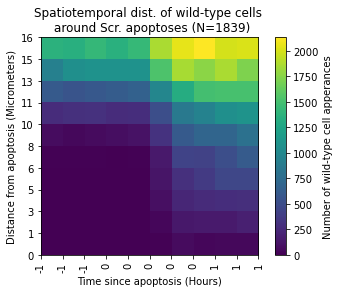

In [12]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 50,
                t_range = 50, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scr. apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type cell apperances', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/Spatiotemporal dist. of wild-type mitoses 
 around Scr. apoptoses (N=1839).pdf


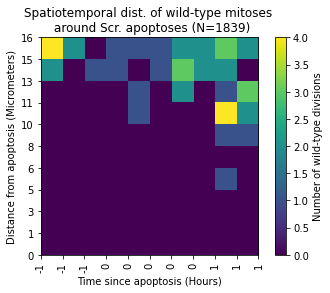

In [13]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 50,
                t_range = 50, 
                title = 'Spatiotemporal dist. of wild-type mitoses \n around Scr. apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True)

/tmp/ipykernel_293801/4238316682.py:1: RuntimeWarning: invalid value encountered in true_divide
  render.plot_cumulative(input_2d_hist = N_events/N_cells,


Plot saved at  /home/nathan/Spatiotemporal dist. of probability of wild-type division 
 around Scr. apoptoses (N=1839).pdf


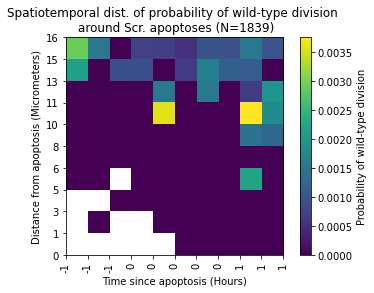

In [14]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 50,
                t_range = 50, 
                title = 'Spatiotemporal dist. of probability of wild-type division \n around Scr. apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Probability of wild-type division', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True)

# 5) Miscellaneous section: segregating cumulative plots based on experiment type

50:50 expt

In [ ]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types'
Path(save_path).mkdir(parents=True, exist_ok=True)

In [ ]:
expt_list_5050 = ['GV0794/Pos4',
                 'GV0794/Pos7',
                 'GV0794/Pos16',
                 'GV0795/Pos4',
                 'GV0795/Pos7',
                 'GV0795/Pos17',
                 'GV0796/Pos4',
                 'GV0796/Pos7',
                 'GV0796/Pos21',
                 'GV0796/Pos22',
                 'GV0797/Pos4',
                 'GV0797/Pos7',
                 'GV0797/Pos20',
                 'GV0797/Pos21',
                 'GV0798/Pos4',
                 'GV0798/Pos7',
                 'GV0798/Pos20',
                 'GV0798/Pos21',
                 'GV0800/Pos4', 
                 'GV0800/Pos7',
                 'GV0800/Pos16',
                 'GV0801/Pos4',
                 'GV0802/Pos4',
                 'GV0804/Pos4',
                 'GV0805/Pos4',
                 'GV0806/Pos4',
                 'GV0807/Pos4',
                 'GV0812/Pos0',
                 'GV0812/Pos1',
                 'GV0812/Pos2',
                 'GV0812/Pos3',
                 'GV0812/Pos4',
                 'GV0812/Pos5',
                 'GV0813/Pos0',
                 'GV0813/Pos1',
                 'GV0813/Pos2',
                 'GV0813/Pos3',
                 'GV0813/Pos4',
                 'GV0813/Pos5',
                 'GV0814/Pos0',
                 'GV0814/Pos11',
                 'GV0814/Pos12',
                 'GV0814/Pos23',
                 'GV0815/Pos0',
                 'GV0815/Pos11',
                 'GV0815/Pos12',
                 'GV0815/Pos23',
                 'GV0816/Pos0',
                 'GV0816/Pos13',
                 'GV0816/Pos14',
                 'GV0816/Pos23',
                 'GV0817/Pos0',
                 'GV0817/Pos11',
                 'GV0817/Pos12',
                 'GV0817/Pos23',
                 'GV0818/Pos12',
                 'GV0818/Pos13',
                 'GV0819/Pos0',
                 'GV0819/Pos1',
                 'GV0819/Pos2',
                 'GV0819/Pos3',
                 'GV0819/Pos4',
                 'GV0819/Pos5',
                 'GV0820/Pos0',
                 'GV0820/Pos1',
                 'GV0820/Pos2',
                 'GV0820/Pos3',
                 'GV0820/Pos4',
                 'GV0820/Pos5']

In [ ]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_5050:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

In [ ]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

In [ ]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

In [ ]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400,  
                title = 'Spatiotemporal dist. of probability of Scribble division \n around wild-type apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

90:10 wt:scr

In [ ]:
expt_list_9010 = ['GV0794/Pos3',
 'GV0794/Pos8',
 'GV0794/Pos15',
 'GV0795/Pos3',
 'GV0795/Pos8',
 'GV0795/Pos16',
 'GV0796/Pos3',
 'GV0796/Pos8',
 'GV0796/Pos19',
 'GV0796/Pos20',
 'GV0797/Pos3',
 'GV0797/Pos8',
 'GV0797/Pos18',
 'GV0797/Pos19',
 'GV0798/Pos3',
 'GV0798/Pos8',
 'GV0798/Pos18',
 'GV0798/Pos19',
 'GV0800/Pos3',
 'GV0800/Pos8',
 'GV0800/Pos15',
 'GV0801/Pos3',
 'GV0802/Pos3',
 'GV0804/Pos3',
 'GV0805/Pos3',
 'GV0806/Pos3',
 'GV0807/Pos3']

In [ ]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_9010:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

In [ ]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

In [ ]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

In [ ]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

10:90 wt:scr

In [ ]:
expt_list_1090 = ['GV0794/Pos5',
 'GV0794/Pos6',
 'GV0795/Pos5',
 'GV0795/Pos6',
 'GV0795/Pos18',
 'GV0796/Pos5',
 'GV0796/Pos6',
 'GV0796/Pos23',
 'GV0796/Pos24',
 'GV0797/Pos5',
 'GV0797/Pos6',
 'GV0797/Pos22',
 'GV0797/Pos23',
 'GV0798/Pos5',
 'GV0798/Pos6',
 'GV0798/Pos22',
 'GV0798/Pos23',
 'GV0800/Pos5',
 'GV0800/Pos6',
 'GV0800/Pos17',
 'GV0801/Pos5',
 'GV0802/Pos5',
 'GV0804/Pos5',
 'GV0805/Pos5',
 'GV0806/Pos5',
 'GV0807/Pos5']

In [ ]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_1090:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

In [ ]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

In [ ]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400,  
                title = 'Spatiotemporal dist. of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

In [ ]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Write a function to do a time evolving plot that iteratively adds single cell heat maps according to the apoptosis time?